In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
import os
pd.set_option('display.max_columns', 30)

In [2]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [3]:
# Import samplesheets
cols = ["model_id", "BROAD_ID", "tissue", "cancer_type"]
col_rename = dict(
    ModelID="BROAD_ID",
    SangerModelID="model_id",
    SampleCollectionSite="tissue",
    OncotreeLineage="cancer_type",
)
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv")

ss_depmap = pd.read_csv(f"{data_folder}/depmap24Q4/Model.csv")
ss_depmap.rename(columns=col_rename, inplace=True)

# Map sample IDs to Sanger IDs
samplesheet = pd.concat(
    [
        ss_cmp[cols].dropna().assign(source="sanger"),
        ss_depmap[cols].dropna().assign(source="broad"),
    ]
)
samplesheet = samplesheet.groupby("model_id").first().reset_index()
samplesheet.replace(
    {
        "tissue": dict(
            large_intestine="Large Intestine",
            lung="Lung",
            ovary="Ovary",
            haematopoietic_and_lymphoid_tissue="Haematopoietic and Lymphoid",
            bone_marrow="Other tissue",
            upper_aerodigestive_tract="Other tissue",
            ascites="Other tissue",
            pleural_effusion="Other tissue",
        )
    },
    inplace=True,
)
tissue_map = samplesheet.set_index("model_id").to_dict()["tissue"]

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])

In [4]:
samplesheet.head()

model_id    BROAD_ID                       tissue          cancer_type  \
0  SIDM00001  ACH-000405  Haematopoietic and Lymphoid  Other Blood Cancers   
1  SIDM00002  ACH-002340    Peripheral Nervous System        Neuroblastoma   
2  SIDM00003  ACH-002159                         Skin             Melanoma   
3  SIDM00005  ACH-000044                       Breast     Breast Carcinoma   
4  SIDM00006  ACH-001552                         Skin  Other Solid Cancers   

   source  
0  sanger  
1  sanger  
2  sanger  
3  sanger  
4  sanger

In [5]:
samplesheet['tissue'].unique()

array(['Haematopoietic and Lymphoid', 'Peripheral Nervous System', 'Skin',
       'Breast', 'Ovary', 'Large Intestine', 'Esophagus', 'Lung',
       'Head and Neck', 'Central Nervous System', 'Kidney', 'Soft Tissue',
       'Bladder', 'Bone', 'Thyroid', 'Endometrium', 'Stomach', 'Pancreas',
       'Liver', 'Cervix', 'Eye', 'Prostate', 'Biliary Tract', 'Uterus',
       'Testis', 'Other tissue', 'Placenta', 'Small Intestine',
       'Adrenal Gland', 'Vulva', 'Unknown'], dtype=object)

In [6]:
PALETTE_TTYPE = {
    "Lung": "#007fff",
    "Prostate": "#665d1e",
    "Stomach": "#ffbf00",
    "Central Nervous System": "#fbceb1",
    "Skin": "#ff033e",
    "Bladder": "#ab274f",
    "Haematopoietic and Lymphoid": "#d5e6f7",
    "Kidney": "#7cb9e8",
    "Thyroid": "#efdecd",
    "Soft Tissue": "#8db600",
    "Head and Neck": "#e9d66b",
    "Ovary": "#b284be",
    "Bone": "#b2beb5",
    "Endometrium": "#10b36f",
    "Breast": "#6e7f80",
    "Pancreas": "#ff7e00",
    "Peripheral Nervous System": "#87a96b",
    "Cervix": "#c9ffe5",
    "Large Intestine": "#9f2b68",
    "Liver": "#00ffff",
    "Vulva": "#008000",
    "Esophagus": "#cd9575",
    "Biliary Tract": "#72a0c1",
    "Other tissue": "#a32638",
    "Small Intestine": "#9966cc",
    "Placenta": "#f19cbb",
    "Testis": "#e32636",
    "Adrenal Gland": "#3b7a57",
    "Uterus": "#7a3b5e",
    "Unknown": "#a32638",
    "Eye": "#ff1493",
}

In [7]:
def make_sl_binary_matrix(
    gexp_df,
    crispr_df,
    df_res_vae_annot_filtered_top,
    GEXP_THRESHOLD=0,
    CRISPR_THRESHOLD=-0.5,
):
    """
    Returns a binary matrix (DataFrame) of shape (n_samples, n_pairs) where
    1 indicates gexp_df[x_id] < GEXP_THRESHOLD and crispr_df[y_id] < CRISPR_THRESHOLD
    for a given sample.
    """
    samples = gexp_df.index
    col_dict = {}

    for _, row in df_res_vae_annot_filtered_top.iterrows():
        y_id = row["y_id"]
        x_id = row["x_id"]
        col_name = f"{y_id}:{x_id}"

        if (x_id in gexp_df.columns) and (y_id in crispr_df.columns):
            gexp_cond = gexp_df[x_id] < GEXP_THRESHOLD
            crispr_cond = crispr_df[y_id] < CRISPR_THRESHOLD
            col_dict[col_name] = (gexp_cond & crispr_cond).astype(int)
        else:
            # If gene not present, fill with 0s
            col_dict[col_name] = pd.Series(0, index=samples, dtype=int)

    # Create DataFrame from dict
    result = pd.DataFrame(col_dict, index=samples)
    return result

In [8]:
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import warnings


def pairwise_mcc(sl_binary_matrix, mutations_measured, n_jobs=80):
    """
    Calculate the pairwise Matthews correlation coefficient (MCC) between columns of
    sl_binary_matrix and columns of mutations_measured, in parallel.

    Returns a DataFrame of shape (sl_binary_matrix.shape[1], mutations_measured.shape[1])
    """
    # Ensure the indices are aligned
    common_idx = sl_binary_matrix.index.intersection(mutations_measured.index)
    sl_bin = sl_binary_matrix.loc[common_idx]
    muts = mutations_measured.loc[common_idx]

    sl_cols = sl_bin.columns
    mut_cols = muts.columns

    def compute_mcc(sl_col, mut_col):
        x = sl_bin[sl_col].astype("int")
        y = muts[mut_col].astype("int")
        # If either column has only one unique value, MCC is undefined
        if (x.nunique(dropna=True) < 2) or (y.nunique(dropna=True) < 2):
            # print(
            #     f"Only one unique value for {sl_col} and {mut_col}, {x.nunique(dropna=True)}, {y.nunique(dropna=True)}"
            # )
            return np.nan
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                return matthews_corrcoef(x, y)
        except ValueError as e:
            print(f"Error for {sl_col} and {mut_col}: {e}")
            return np.nan

    # Prepare all pairs
    pairs = [(i, j) for i in range(len(sl_cols)) for j in range(len(mut_cols))]

    # Parallel computation
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_mcc)(sl_cols[i], mut_cols[j])
        for i, j in tqdm(pairs, desc="MCC pairs")
    )

    # Reshape results into DataFrame
    mcc_matrix = np.array(results).reshape(len(sl_cols), len(mut_cols))
    mcc_df = pd.DataFrame(mcc_matrix, index=sl_cols, columns=mut_cols)
    return mcc_df

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict  # For legend handling


def plot_scatter_for_row(
    row, gexp_df, cas9_df, mutations_measured, tissue_map, PALETTE_TTYPE
):
    """
    Generates a scatter plot for a given row from mcc_melt_df_filtered.

    Args:
        row (pd.Series): A row from mcc_melt_df_filtered.
        gexp_df (pd.DataFrame): Gene expression data.
        cas9_df (pd.DataFrame): CRISPR screen data.
        mutations_measured (pd.DataFrame): Mutation data.
        tissue_map (dict): Mapping from sample ID (model_id) to tissue type.
        PALETTE_TTYPE (dict): Color palette for tissue types.

    Returns:
        matplotlib.figure.Figure: The generated figure object.
    """
    # --- 1. Extract IDs and data ---
    y_id, x_id = row["CRISPR:GEXP"].split(":")
    mut_col = row["mut_col"]
    mcc_val = row["mcc"]

    # Ensure IDs exist in respective dataframes
    if x_id not in gexp_df.columns:
        print(f"Error: Gene expression ID {x_id} not found.")
        return None
    if y_id not in cas9_df.columns:
        print(f"Error: CRISPR ID {y_id} not found.")
        return None
    if mut_col not in mutations_measured.columns:
        print(f"Error: Mutation column {mut_col} not found.")
        return None

    # --- Get fdr_vae value ---
    fdr_vae_val = row["fdr_vae"]

    # --- 2. Find common samples ---
    common_samples = (
        set(gexp_df.index)
        & set(cas9_df.index)
        & set(mutations_measured.index)
        & set(tissue_map.keys())
    )

    if not common_samples:
        print("Error: No common samples found for plotting.")
        return None

    common_samples = list(common_samples)

    # --- 3. Prepare plotting dataframe ---
    tissue_types_for_plot = [tissue_map.get(sample) for sample in common_samples]

    plot_df = pd.DataFrame(
        {
            "GEXP": gexp_df.loc[common_samples, x_id],
            "CRISPR": cas9_df.loc[common_samples, y_id],
            "Mutation": mutations_measured.loc[common_samples, mut_col],
            "TissueType": tissue_types_for_plot,
        },
        index=common_samples,
    ).dropna()

    plot_df["MutationStatus"] = plot_df["Mutation"].apply(
        lambda x: "Mutated" if x == 1 else "Wildtype"
    )

    # --- 4. Create Plot ---
    fig, ax = plt.subplots(figsize=(5, 5))

    # Data for Wildtype and Mutated points
    df_wt = plot_df[plot_df["MutationStatus"] == "Wildtype"]
    df_mut = plot_df[plot_df["MutationStatus"] == "Mutated"]

    # Plot Wildtype points
    if not df_wt.empty:
        sns.scatterplot(
            data=df_wt,
            x="GEXP",
            y="CRISPR",
            hue="TissueType",
            palette=PALETTE_TTYPE,
            marker="o",  # Wildtype marker
            ax=ax,
            s=50,
            alpha=0.8,
            edgecolor="none",  # No border for wildtype
            linewidths=0,  # Linewidth 0 for wildtype (scalar)
            legend="auto",  # Let seaborn handle legend for this layer
        )

    # Plot Mutated points (will be drawn on top of Wildtype if plotted second)
    if not df_mut.empty:
        sns.scatterplot(
            data=df_mut,
            x="GEXP",
            y="CRISPR",
            hue="TissueType",
            palette=PALETTE_TTYPE,
            marker="X",  # Mutated marker
            ax=ax,
            s=50,  # Size for mutated markers
            alpha=0.8,
            edgecolor="red",  # Red border for mutated (scalar)
            linewidths=1.0,  # Linewidth 1.5 for mutated (scalar)
            legend="auto",  # Let seaborn handle legend for this layer
        )

    # --- 5. Customize Plot ---
    ax.set_title(f"{y_id} vs {x_id}\nMutation: {mut_col} (MCC={mcc_val:.3f})")
    ax.set_xlabel(f"{x_id} (GEXP)")
    ax.set_ylabel(f"{y_id} (CRISPR)")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Consolidate legend
    handles, labels = ax.get_legend_handles_labels()

    # Create a dictionary to preserve the first occurrence of each label and its handle
    # This helps if hue categories are repeated across wt/mut plots
    unique_entries = OrderedDict()

    # Add MutationStatus legend items manually if desired
    # For simplicity, this will create legend based on hue (TissueType)
    # and the markers will indicate the mutation status within those hue categories

    # Create explicit handles for "Wildtype" and "Mutated" for the legend
    # Only add if there are corresponding points
    legend_elements = []
    if not df_wt.empty:
        legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label="Wildtype",
                markerfacecolor="grey",
                markersize=7,
                markeredgecolor="black",
            )
        )  # 'w' for white, 'grey' for fill
    if not df_mut.empty:
        legend_elements.append(
            plt.Line2D(
                [0],
                [0],
                marker="X",
                color="w",
                label="Mutated",
                markerfacecolor="grey",
                markersize=7,
                markeredgecolor="red",
                markeredgewidth=1.5,
            )
        )

    # Add original hue handles if they are not already covered by explicit ones
    # This part ensures TissueType legend is also present
    # We need to be careful not to duplicate legend entries

    # Get hue handles and labels
    hue_handles, hue_labels = [], []
    temp_handles, temp_labels = ax.get_legend_handles_labels()

    # Filter out the manually added "Wildtype" and "Mutated" if they somehow got in
    # (though they shouldn't as they are not part of sns hue)
    processed_labels = set(["Wildtype", "Mutated"])

    for handle, label in zip(temp_handles, temp_labels):
        if label not in processed_labels:
            if label not in unique_entries:  # Keep unique TissueType entries
                unique_entries[label] = handle
                processed_labels.add(label)

    final_handles = legend_elements + list(unique_entries.values())
    final_labels = [h.get_label() for h in legend_elements] + list(
        unique_entries.keys()
    )

    ax.legend(
        handles=final_handles,
        labels=final_labels,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        ncol=2,
    )

    # Add annotation for sample counts
    n_wt = (plot_df["MutationStatus"] == "Wildtype").sum()
    n_mut = (plot_df["MutationStatus"] == "Mutated").sum()
    annotation_text = f"Samples:\nWildtype: {n_wt}\nMutated: {n_mut}"
    if fdr_vae_val is not None:
        annotation_text += f"\nfdr_vae: {fdr_vae_val:.2e}"
    ax.annotate(
        annotation_text,
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=9,
        ha="left",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5),
    )

    return fig

# MCC with mutation background

## 2023 mutations


In [48]:
timestamp = "20250225_145621"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [49]:
mutations_measured = (
    pd.read_csv(f"{data_folder}/mutations_summary_20250318.csv", index_col=0)
    .assign(value=1)
    .query("cancer_driver == True")
)
mutations_measured = pd.pivot_table(
    mutations_measured,
    index="model_id",
    columns="gene_symbol",
    values="value",
    aggfunc="first",
    fill_value=0,
)

In [50]:
mutations_measured.head()

gene_symbol  ABCB1  ABI1  ABL1  ABL2  ACVR1  ACVR2A  AFF1  AFF3  AJUBA  AKT1  \
model_id                                                                       
SIDM00001        0     0     0     0      0       0     0     0      0     0   
SIDM00002        0     0     0     0      0       0     0     0      0     0   
SIDM00003        0     0     0     0      0       0     0     0      0     0   
SIDM00006        0     0     0     0      0       0     0     0      0     0   
SIDM00007        0     0     0     0      0       0     0     0      0     0   

gene_symbol  AKT2  AKT3  ALB  ALK  AMER1  ...  ZFP36L1  ZFX  ZNF165  ZNF208  \
model_id                                  ...                                 
SIDM00001       0     0    0    0      0  ...        0    0       0       0   
SIDM00002       0     0    0    0      0  ...        0    0       0       0   
SIDM00003       0     0    0    0      0  ...        0    0       0       0   
SIDM00006       0     0    0    0      0  ...        0    0       0       0   
SIDM00007       0     0    0    0      0  ...        0    0       0       0   

gene_symbol  ZNF331  ZNF429  ZNF521  ZNF626  ZNF680  ZNF721  ZNF814  ZNF93  \
model_id                                                                     
SIDM00001         0       0       0       0       0       0       0      0   
SIDM00002         0       0       0       0       0       0       0      0   
SIDM00003         0       0       0       0       0       0       0      0   
SIDM00006         0       0       0       0       0       0       0      0   
SIDM00007         0       0       0       0       0       0       0      0   

gene_symbol  ZNRF3  ZRSR2  ZXDB  
model_id                         
SIDM00001        0      0     0  
SIDM00002        0      0     0  
SIDM00003        0      0     0  
SIDM00006        0      0     0  
SIDM00007        0      0     0  

[5 rows x 607 columns]

In [51]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
gexp_measured = gexp_measured[gexp_measured.index.isin(gexp_df.index)]

In [52]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
cas9_measured = cas9_measured[cas9_measured.index.isin(cas9_df.index)]

In [53]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))

In [54]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [55]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [56]:
df_res_vae_annot_filtered = df_res_vae_annot.query("entropy > 0.5")
df_res_vae_annot_filtered_top = df_res_vae_annot_filtered.query("fdr_vae < 0.0001")

In [57]:
df_res_vae_annot_filtered_top.shape

(703, 19)

In [58]:
CRISPR_THRESHOLD = -0.5
GEXP_THRESHOLD = 0

In [59]:
sl_binary_matrix = make_sl_binary_matrix(
    gexp_df, cas9_df, df_res_vae_annot_filtered_top
)
sl_binary_matrix_measured = make_sl_binary_matrix(
    gexp_measured, cas9_measured, df_res_vae_annot_filtered_top
)

In [60]:
# Filter mutations to only include columns with more than 50 mutations
mutations_measured_filtered = mutations_measured.loc[:, mutations_measured.sum() > 20]

In [87]:
mcc_df = pairwise_mcc(sl_binary_matrix, mutations_measured_filtered)
mcc_df_measured = pairwise_mcc(sl_binary_matrix_measured, mutations_measured_filtered)

MCC pairs:   0%|          | 0/95608 [00:00<?, ?it/s]

MCC pairs:   0%|          | 0/95608 [00:00<?, ?it/s]

In [88]:
mcc_df

gene_symbol      ACVR2A       APC  ARHGAP35    ARID1A    ARID1B     ARID2  \
FAM50A:FAM50B  0.094339  0.129890  0.024083  0.048176  0.004422  0.046551   
EIF1AX:EIF1AY -0.018864  0.034938  0.024574  0.036457  0.012327 -0.004323   
DDX3X:DDX3Y    0.041976  0.038323  0.123936  0.124951  0.044911  0.024276   
DDX3X:UTY      0.086577  0.167742  0.093539  0.109861  0.051950  0.046517   
DDX3X:USP9Y    0.082415  0.157806  0.100512  0.106608  0.049700  0.045405   
...                 ...       ...       ...       ...       ...       ...   
SOX10:PMEL          NaN       NaN       NaN       NaN       NaN       NaN   
SOX10:S100B   -0.006717 -0.007233 -0.004270 -0.008879 -0.004846 -0.005149   
SOX10:PLP1    -0.011645 -0.012538 -0.007402 -0.015392 -0.008400 -0.008925   
SOX10:TRIM63  -0.025273 -0.027212 -0.016066 -0.033405 -0.018231  0.026135   
SOX10:MLANA   -0.006717 -0.007233 -0.004270 -0.008879 -0.004846 -0.005149   

gene_symbol       ASXL1     ASXL2    ATF7IP       ATM       ATR       B2M  \
FAM50A:FAM50B  0.023319  0.018304  0.040860  0.028050  0.046280  0.071620   
EIF1AX:EIF1AY -0.091520  0.002641  0.019195  0.045970 -0.008407 -0.001907   
DDX3X:DDX3Y   -0.022310  0.031188  0.029336  0.047499  0.017132  0.030191   
DDX3X:UTY     -0.043061  0.005853  0.084170  0.052259  0.017356  0.040675   
DDX3X:USP9Y   -0.033329  0.011957  0.069859  0.043738  0.023756  0.034455   
...                 ...       ...       ...       ...       ...       ...   
SOX10:PMEL          NaN       NaN       NaN       NaN       NaN       NaN   
SOX10:S100B   -0.005437 -0.003509 -0.004607 -0.005644 -0.003713 -0.003907   
SOX10:PLP1    -0.009424 -0.006083 -0.007986 -0.009784 -0.006436 -0.006773   
SOX10:TRIM63  -0.020454 -0.013203 -0.017333  0.020530 -0.013970 -0.014699   
SOX10:MLANA   -0.005437 -0.003509 -0.004607 -0.005644 -0.003713 -0.003907   

gene_symbol        BAP1       BAX     BCL9L  ...     STAG2    STAT5B  \
FAM50A:FAM50B -0.037456  0.160966  0.109437  ... -0.048442  0.083473   
EIF1AX:EIF1AY  0.002641 -0.093445 -0.051488  ... -0.003624  0.033332   
DDX3X:DDX3Y   -0.054290  0.002759  0.008626  ... -0.055650  0.073944   
DDX3X:UTY     -0.022783  0.010078  0.034993  ... -0.058560  0.083094   
DDX3X:USP9Y   -0.045013  0.005861  0.022829  ... -0.060528  0.077103   
...                 ...       ...       ...  ...       ...       ...   
SOX10:PMEL          NaN       NaN       NaN  ...       NaN       NaN   
SOX10:S100B   -0.003509 -0.006599 -0.004923  ... -0.004767 -0.004001   
SOX10:PLP1    -0.006083 -0.011439 -0.008534  ... -0.008264 -0.006935   
SOX10:TRIM63  -0.013203 -0.024827 -0.018522  ... -0.017936 -0.015051   
SOX10:MLANA   -0.003509 -0.006599 -0.004923  ... -0.004767 -0.004001   

gene_symbol       STK11      TET2    TGFBR2      TP53     TRRAP      UBR5  \
FAM50A:FAM50B -0.037781  0.110717  0.015407 -0.027860  0.025803  0.066837   
EIF1AX:EIF1AY  0.063432 -0.123236  0.041018  0.101212 -0.009584  0.039494   
DDX3X:DDX3Y    0.142403 -0.055094  0.060106  0.134741  0.029257  0.068977   
DDX3X:UTY      0.126349 -0.069838  0.066037  0.133136  0.019055  0.097374   
DDX3X:USP9Y    0.118662 -0.075955  0.074295  0.139591  0.028335  0.089545   
...                 ...       ...       ...       ...       ...       ...   
SOX10:PMEL          NaN       NaN       NaN       NaN       NaN       NaN   
SOX10:S100B   -0.005911 -0.003811 -0.004923  0.020572 -0.005366 -0.005845   
SOX10:PLP1    -0.010247 -0.006607 -0.008534  0.035661 -0.009302 -0.010133   
SOX10:TRIM63  -0.022240 -0.014339 -0.018522 -0.071744  0.023590 -0.021993   
SOX10:MLANA   -0.005911 -0.003811 -0.004923 -0.041091  0.157535 -0.005845   

gene_symbol       USP9X       VHL      WNK2      WNK4       WRN     ZFHX3  \
FAM50A:FAM50B -0.026549 -0.059463  0.054868  0.028683  0.038116  0.025634   
EIF1AX:EIF1AY  0.011805  0.037380  0.014573 -0.025718  0.031054  0.033455   
DDX3X:DDX3Y    0.050117 -0.033265  0.017351  0.044107  0.043031  0.055192   
DDX3X:UTY      0.049119 -0.023572  0.027771  0.03091

In [89]:
mcc_df_measured

gene_symbol      ACVR2A       APC  ARHGAP35    ARID1A    ARID1B     ARID2  \
FAM50A:FAM50B  0.066442  0.150252  0.054070  0.091792  0.050456  0.073220   
EIF1AX:EIF1AY  0.039302  0.026195  0.060572  0.076314  0.005899  0.018680   
DDX3X:DDX3Y    0.037284  0.025649  0.065156  0.071887  0.011627  0.012008   
DDX3X:UTY      0.050794  0.045804  0.061876  0.071944  0.007536  0.020260   
DDX3X:USP9Y    0.042456  0.046960  0.062530  0.066149  0.008354  0.008842   
...                 ...       ...       ...       ...       ...       ...   
SOX10:PMEL    -0.017992 -0.019760 -0.011236 -0.024500 -0.013955 -0.013497   
SOX10:S100B    0.005825  0.034042  0.037894  0.043131  0.022532 -0.023506   
SOX10:PLP1     0.005825  0.034042  0.037894  0.043131  0.022532 -0.023506   
SOX10:TRIM63  -0.011734  0.008646  0.019354  0.011439  0.004930 -0.030514   
SOX10:MLANA   -0.008831  0.012726  0.022272  0.016527  0.007762 -0.029235   

gene_symbol       ASXL1     ASXL2    ATF7IP       ATM       ATR       B2M  \
FAM50A:FAM50B -0.004356  0.015981 -0.005286  0.028528  0.057977  0.071187   
EIF1AX:EIF1AY  0.004873 -0.003888 -0.025847  0.015306  0.013830  0.042563   
DDX3X:DDX3Y    0.010962 -0.000134 -0.007115  0.021564  0.017576  0.046806   
DDX3X:UTY      0.006613 -0.002815  0.003318  0.017093  0.014899  0.043771   
DDX3X:USP9Y    0.007483 -0.002279 -0.009879  0.017987  0.015434  0.044377   
...                 ...       ...       ...       ...       ...       ...   
SOX10:PMEL    -0.014835 -0.009139 -0.011772 -0.015259 -0.009139 -0.010385   
SOX10:S100B   -0.025836  0.054190 -0.020501  0.016550 -0.015916 -0.018087   
SOX10:PLP1    -0.025836  0.054190 -0.020501  0.016550 -0.015916 -0.018087   
SOX10:TRIM63  -0.033539  0.033943 -0.026614  0.099859 -0.020661 -0.023479   
SOX10:MLANA   -0.032134  0.037070 -0.025499  0.106869 -0.019795 -0.022495   

gene_symbol        BAP1       BAX     BCL9L  ...     STAG2    STAT5B  \
FAM50A:FAM50B -0.017586  0.068135 -0.000235  ... -0.011052  0.077079   
EIF1AX:EIF1AY -0.022713  0.002414 -0.018422  ... -0.004663  0.025083   
DDX3X:DDX3Y   -0.019231 -0.010001 -0.026347  ... -0.000161  0.029571   
DDX3X:UTY     -0.021716  0.014188 -0.003862  ... -0.003376  0.026364   
DDX3X:USP9Y   -0.021218 -0.004300 -0.016210  ... -0.002733  0.027004   
...                 ...       ...       ...  ...       ...       ...   
SOX10:PMEL    -0.008452 -0.017247 -0.012537  ... -0.010959 -0.010959   
SOX10:S100B   -0.014719 -0.030036  0.029952  ...  0.039763 -0.019086   
SOX10:PLP1    -0.014719 -0.030036  0.029952  ...  0.039763 -0.019086   
SOX10:TRIM63  -0.019108 -0.038991  0.011992  ...  0.021060 -0.024776   
SOX10:MLANA   -0.018307 -0.037358  0.014850  ...  0.023996 -0.023738   

gene_symbol       STK11      TET2    TGFBR2      TP53     TRRAP      UBR5  \
FAM50A:FAM50B -0.004356  0.078975  0.026705 -0.000721 -0.025144  0.101999   
EIF1AX:EIF1AY  0.027243 -0.039325 -0.011864  0.118715  0.037804  0.045112   
DDX3X:DDX3Y    0.033321 -0.035553 -0.006610  0.106803  0.043231  0.051691   
DDX3X:UTY      0.028978 -0.038243 -0.010361  0.117276  0.039351  0.046988   
DDX3X:USP9Y    0.029846 -0.037704 -0.009611  0.100419  0.040126  0.047927   
...                 ...       ...       ...       ...       ...       ...   
SOX10:PMEL    -0.014835 -0.009139 -0.012783 -0.043000 -0.013263 -0.016078   
SOX10:S100B   -0.025836 -0.015916  0.028584 -0.020127 -0.023098 -0.028001   
SOX10:PLP1    -0.025836 -0.015916  0.028584 -0.020127 -0.023098 -0.028001   
SOX10:TRIM63  -0.033539 -0.020661  0.010704 -0.082996  0.008272 -0.036349   
SOX10:MLANA   -0.032134 -0.019795  0.013555 -0.081295  0.011112 -0.034826   

gene_symbol       USP9X       VHL      WNK2      WNK4       WRN     ZFHX3  \
FAM50A:FAM50B  0.001279 -0.034212  0.112332  0.010752  0.039453 -0.002161   
EIF1AX:EIF1AY -0.012345 -0.037565 -0.004663  0.038790  0.019866  0.053969   
DDX3X:DDX3Y   -0.024294 -0.032298 -0.000161  0.042657  0.007901  0.050549   
DDX3X:UTY      0.004944 -0.036057 -0.003376  0.03989

In [94]:
mcc_df = mcc_df.dropna()
mcc_df_measured = mcc_df_measured.loc[mcc_df.index]

In [95]:
mcc_diff = mcc_df.max() - mcc_df_measured.max()
mcc_diff.sort_values(ascending=False)


gene_symbol
EZH2        0.169465
BRAF        0.165053
RB1         0.158510
CARD11      0.123260
MUTYH       0.118728
              ...   
RPL22      -0.136943
KMT2B      -0.141280
ARID1A     -0.153694
ARHGAP35   -0.154060
BMPR2      -0.169842
Length: 136, dtype: float64

In [100]:
mcc_diff_all = mcc_df.abs() - mcc_df_measured.abs()

Text(0.5, 9.444444444444438, 'Difference in Maximum MCC (MOSA - Measured)')

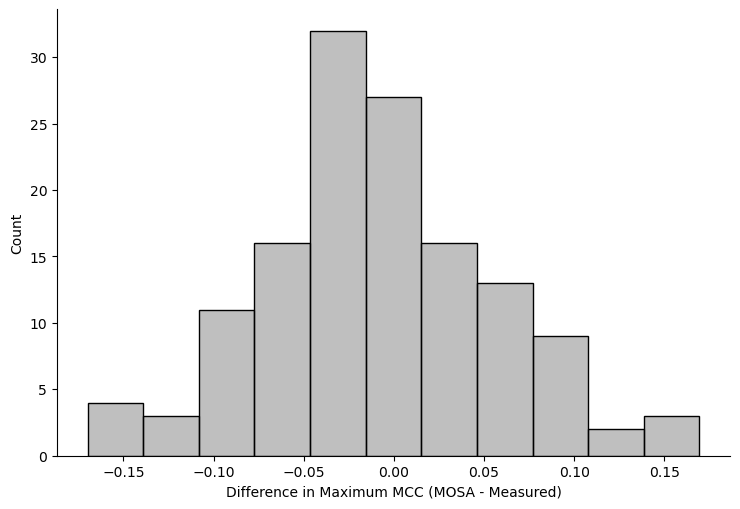

In [96]:
sns.displot(
    data=mcc_diff,
    kind="hist",
    fill=True,
    alpha=0.5,
    height=5,
    aspect=1.5,
    legend=True,
    color="grey",
)
plt.xlabel("Difference in Maximum MCC (MOSA - Measured)")

Text(0.5, 9.444444444444438, 'Difference in absolute MCC (MOSA - Measured)')

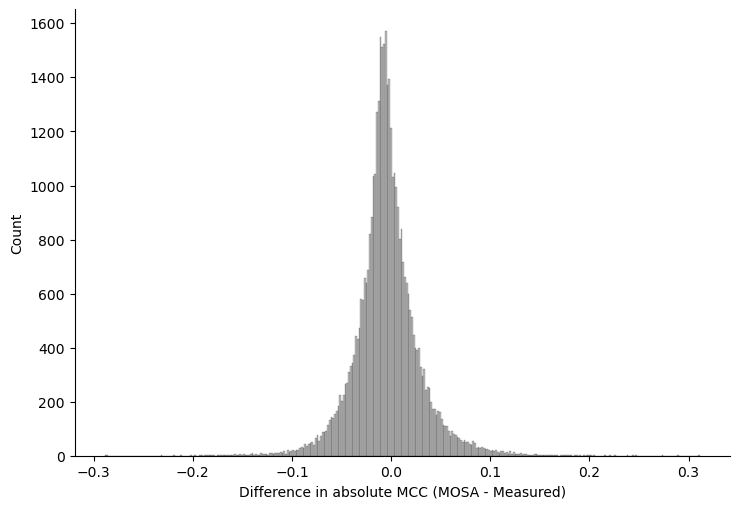

In [102]:
sns.displot(
    data=mcc_diff_all.stack(),
    kind="hist",
    fill=True,
    alpha=0.5,
    height=5,
    aspect=1.5,
    legend=True,
    color="grey",
)
plt.xlabel("Difference in absolute MCC (MOSA - Measured)")

/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 9.444444444444438, 'Maximum  MCC')

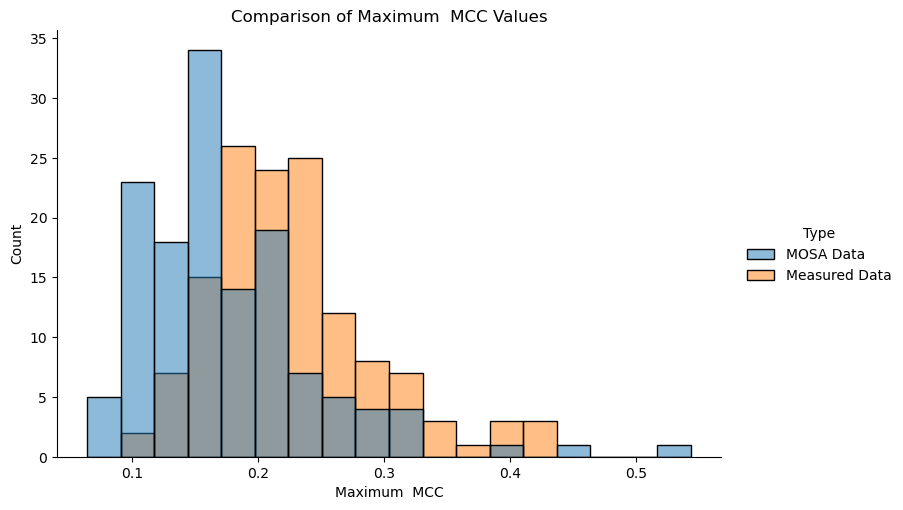

In [61]:
# Create a DataFrame to combine both distributions
combined_data = pd.DataFrame({
    'MCC': pd.concat([mcc_df.max(), mcc_df_measured.max()]),
    'Type': ['MOSA Data'] * len(mcc_df.max()) + ['Measured Data'] * len(mcc_df_measured.max())
})

# Plot both distributions in one figure
sns.displot(
    data=combined_data, 
    x='MCC', 
    hue='Type', 
    kind='hist', 
    fill=True, 
    alpha=0.5,
    height=5, 
    aspect=1.5,
    legend=True
)
plt.title('Comparison of Maximum  MCC Values')
plt.xlabel('Maximum  MCC')


/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 9.444444444444438, 'Minimum  MCC')

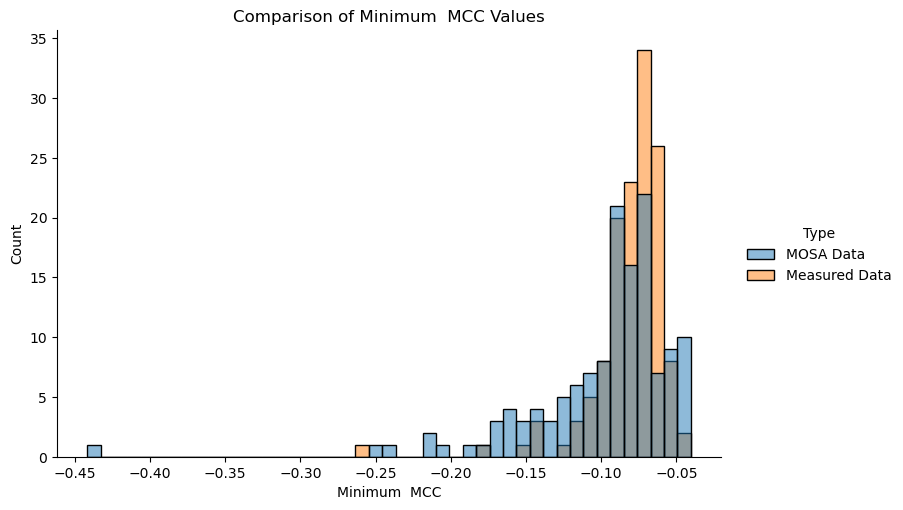

In [63]:
# Create a DataFrame to combine both distributions
combined_data = pd.DataFrame(
    {
        "MCC": pd.concat([mcc_df.min(), mcc_df_measured.min()]),
        "Type": ["MOSA Data"] * len(mcc_df.min())
        + ["Measured Data"] * len(mcc_df_measured.min()),
    }
)

# Plot both distributions in one figure
sns.displot(
    data=combined_data,
    x="MCC",
    hue="Type",
    kind="hist",
    fill=True,
    alpha=0.5,
    height=5,
    aspect=1.5,
    legend=True,
)
plt.title("Comparison of Minimum  MCC Values")
plt.xlabel("Minimum  MCC")

In [34]:
mcc_melt_df = mcc_df.reset_index().melt(
    id_vars="index", var_name="mut_col", value_name="mcc"
)
mcc_melt_df = mcc_melt_df.rename(columns={"index": "CRISPR:GEXP"})
mcc_melt_df.round(5).to_csv(
    f"../reports/vae/crispr/{timestamp}_mcc_results.csv", index=False
)

In [32]:
mcc_melt_measured_df = mcc_df_measured.reset_index().melt(
    id_vars="index", var_name="mut_col", value_name="mcc"
)
mcc_melt_measured_df = mcc_melt_measured_df.rename(columns={"index": "CRISPR:GEXP"})
mcc_melt_measured_df.round(5).to_csv(
    f"../reports/vae/crispr/{timestamp}_mcc_results_measured.csv", index=False
)

In [35]:
mcc_melt_df_filtered = mcc_melt_df.query("mcc > 0.3").sort_values(
    "mcc", ascending=False
)
mcc_melt_df_filtered_measured = mcc_melt_measured_df.query("mcc > 0.3").sort_values(
    "mcc", ascending=False
)


In [36]:
mcc_melt_df_filtered.groupby("mut_col").size().sort_values(ascending=False)

mut_col
BRAF      6
EZH2      3
VHL       3
ACVR2A    1
CHD2      1
FAT4      1
QKI       1
RB1       1
dtype: int64

In [37]:
mcc_melt_df_filtered_measured.groupby("mut_col").size().sort_values(ascending=False)

mut_col
ACVR2A    2
BRAF      2
RNF43     2
VHL       2
RPL22     2
QKI       2
KMT2B     2
NCOR1     2
ARID1A    1
JAK1      1
FLCN      1
FAT4      1
CHD2      1
BMPR2     1
BAX       1
PTPN13    1
PRDM2     1
dtype: int64

In [38]:
# Split CRISPR:GEXP into y_id and x_id
mcc_melt_df_filtered[['y_id', 'x_id']] = mcc_melt_df_filtered['CRISPR:GEXP'].str.split(':', expand=True)

# Create a mapping dictionary from df_res_vae_annot_filtered_top
fdr_map = {}
for _, row in df_res_vae_annot_filtered_top.iterrows():
    key = f"{row['y_id']}:{row['x_id']}"
    fdr_map[key] = row['fdr_vae']

# Map the fdr_vae values
mcc_melt_df_filtered['fdr_vae'] = mcc_melt_df_filtered['CRISPR:GEXP'].map(fdr_map)
mcc_melt_df_filtered = mcc_melt_df_filtered.drop(columns=["y_id", "x_id"])

In [40]:
mcc_melt_df_filtered_measured[["y_id", "x_id"]] = mcc_melt_df_filtered_measured[
    "CRISPR:GEXP"
].str.split(":", expand=True)

# Create a mapping dictionary from df_res_vae_annot_filtered_top
fdr_map = {}
for _, row in df_res_vae_annot_filtered_top.iterrows():
    key = f"{row['y_id']}:{row['x_id']}"
    fdr_map[key] = row["fdr_vae"]

# Map the fdr_vae values
mcc_melt_df_filtered_measured["fdr_vae"] = mcc_melt_df_filtered_measured[
    "CRISPR:GEXP"
].map(fdr_map)
mcc_melt_df_filtered_measured = mcc_melt_df_filtered_measured.drop(
    columns=["y_id", "x_id"]
)

In [41]:
mcc_melt_df_filtered_measured

CRISPR:GEXP mut_col       mcc       fdr_vae
79816      WRN:UBE2E2   RPL22  0.431467  3.515328e-05
48181      WRN:UBE2E2   KMT2B  0.428468  3.515328e-05
37636      WRN:UBE2E2    FAT4  0.415382  3.515328e-05
92027      PAX8:SOX17     VHL  0.404721  1.718881e-05
92065     PAX8:CLDN16     VHL  0.399317  1.516272e-06
48133        WRN:MLH1   KMT2B  0.396612  4.143926e-07
13031      WRN:UBE2E2   BMPR2  0.387532  3.515328e-05
377        WRN:UBE2E2  ACVR2A  0.386789  3.515328e-05
13958  SOX10:ADAMTSL1    BRAF  0.378518  4.766437e-05
79768        WRN:MLH1   RPL22  0.373049  4.143926e-07
14043    SOX10:OCIAD2    BRAF  0.368923  4.498582e-05
329          WRN:MLH1  ACVR2A  0.358328  4.143926e-07
21467      WRN:UBE2E2    CHD2  0.351180  3.515328e-05
45927       WRN:THADA    JAK1  0.342252  3.784600e-06
79113      WRN:UBE2E2   RNF43  0.333020  3.515328e-05
79065        WRN:MLH1   RNF43  0.331830  4.143926e-07
76301      WRN:UBE2E2     QKI  0.329666  3.515328e-05
72890     MBTPS2:SQLE  PTPN13  0.321441  1.270830e-05
70677      WRN:UBE2E2   PRDM2  0.320644  3.515328e-05
9516       WRN:UBE2E2     BAX  0.317755  3.515328e-05
59459       FDPS:SQLE   NCOR1  0.313129  7.880638e-07
2486       WRN:UBE2E2  ARID1A  0.313049  3.515328e-05
59429      WRN:UBE2E2   NCOR1  0.311390  3.515328e-05
40018         PAX8:CP    FLCN  0.306867  8.199047e-08
76253        WRN:MLH1     QKI  0.304964  4.143926e-07

In [175]:
mcc_melt_df_filtered

CRISPR:GEXP mut_col       mcc       fdr_vae
13958  SOX10:ADAMTSL1    BRAF  0.543571  4.766437e-05
14043    SOX10:OCIAD2    BRAF  0.497735  4.498582e-05
91933       HNF1B:FGA     VHL  0.447232  8.533206e-06
13634     MDM2:INPP5D    BRAF  0.393444  1.347052e-06
92067  HNF1B:SERPINA6     VHL  0.390656  1.507265e-05
34504       NMT1:NMT2    EZH2  0.389861  6.650182e-31
13715    MDM2:SPATA18    BRAF  0.373236  5.664414e-06
13504   FERMT2:FERMT1    BRAF  0.353968  1.825904e-11
92027      PAX8:SOX17     VHL  0.348695  1.718881e-05
21467      WRN:UBE2E2    CHD2  0.317655  3.515328e-05
37636      WRN:UBE2E2    FAT4  0.314645  3.515328e-05
14027    CHMP4B:PTPN6    BRAF  0.311753  6.095514e-05
35096    EFR3A:ADGRF1    EZH2  0.310022  1.297074e-05
377        WRN:UBE2E2  ACVR2A  0.309979  3.515328e-05
76301      WRN:UBE2E2     QKI  0.309205  3.515328e-05
34468     TTC7A:TTC7B    EZH2  0.307039  2.085084e-80
77751     PSMB6:PSMB9     RB1  0.302194  2.350948e-06

In [61]:
df_res_vae_annot.query("`y_id` == 'SOX10' and `x_id` == 'ADAMTSL1'")

y_id      x_id  n_orig  beta_orig  lr_orig  covs_orig     pval_orig  \
3730  SOX10  ADAMTSL1   965.0     0.1417  24.2648      208.0  8.395946e-07   

      fdr_orig   n_vae  beta_vae    lr_vae  covs_vae      pval_vae   fdr_vae  \
3730  0.014348  1532.0    0.1249  32.34744     211.0  1.289272e-08  0.000048   

      skew_orig  skew_mosa               target_detailed target  entropy  
3730   -3.75511   -3.51171  No link; Gene not in network      -  0.75371

In [178]:
mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'TTC7A:TTC7B'")

CRISPR:GEXP mut_col       mcc       fdr_vae
34468  TTC7A:TTC7B    EZH2  0.307039  2.085084e-80

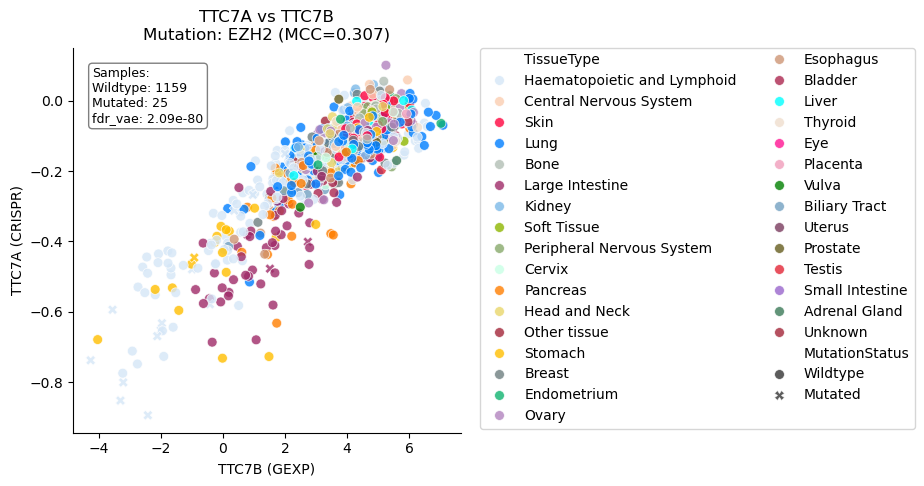

In [180]:
# Call the plotting function
fig = plot_scatter_for_row(
    mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'TTC7A:TTC7B'").iloc[0],
    gexp_df,
    cas9_df,
    mutations_measured,
    tissue_map,
    PALETTE_TTYPE,
)
plt.show()  # Add this line to display the plot in the notebook

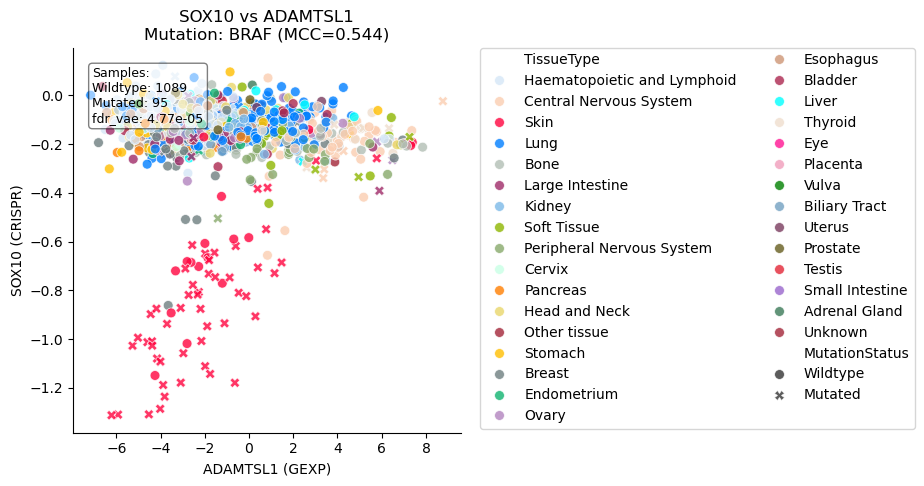

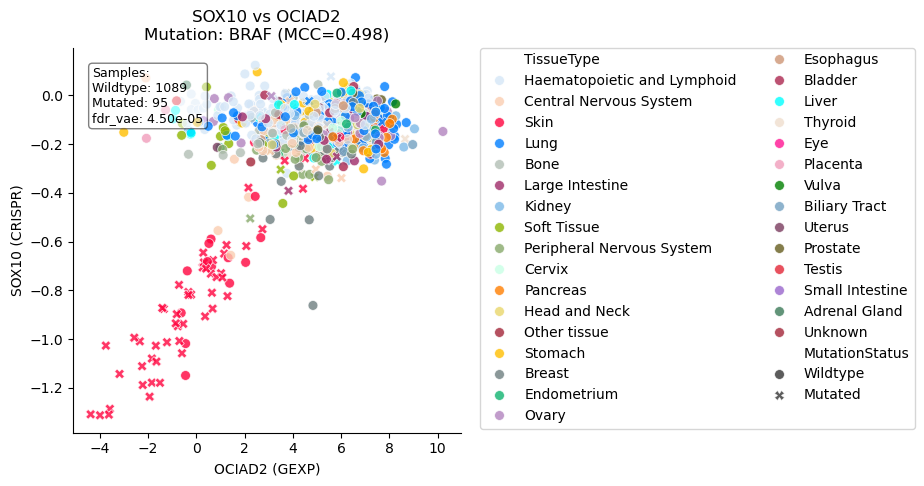

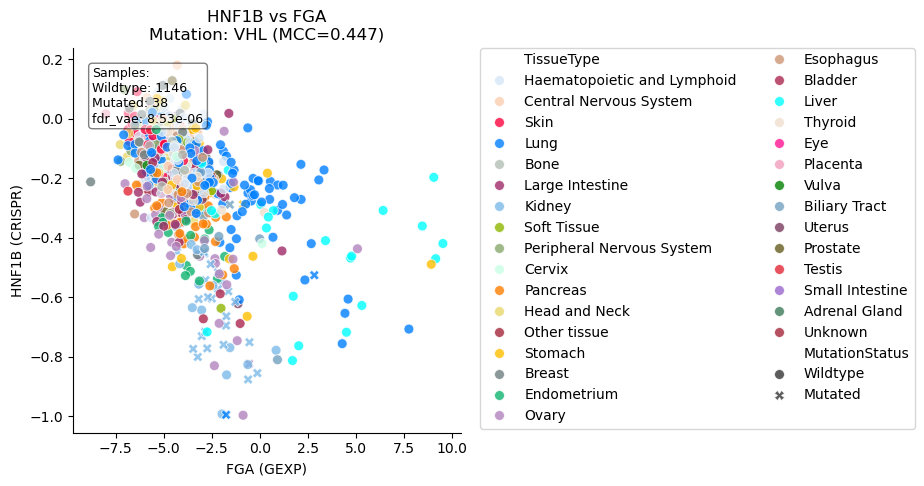

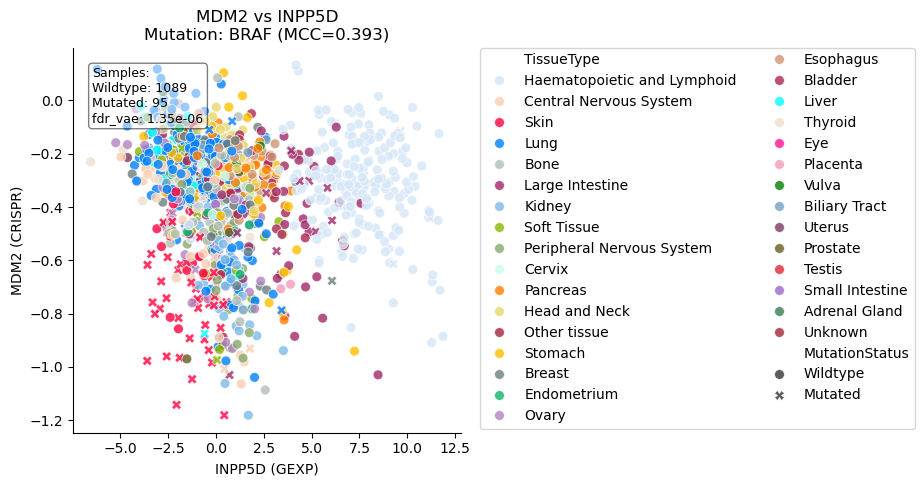

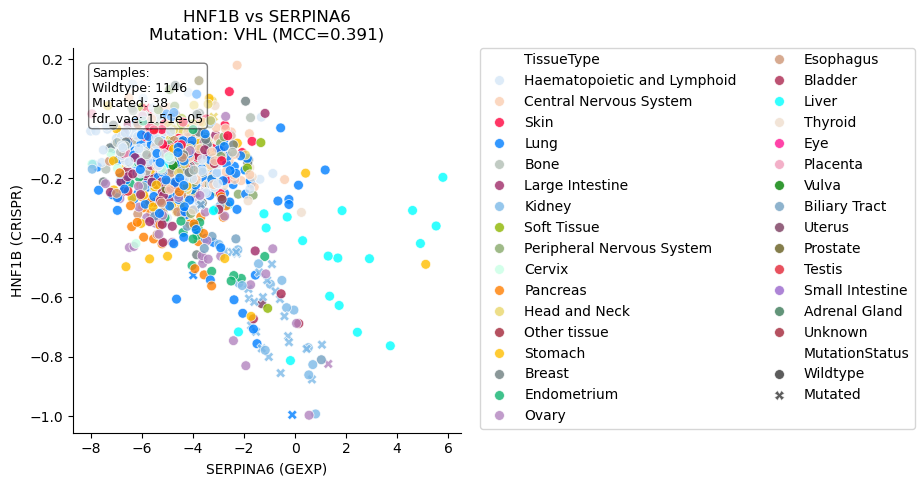

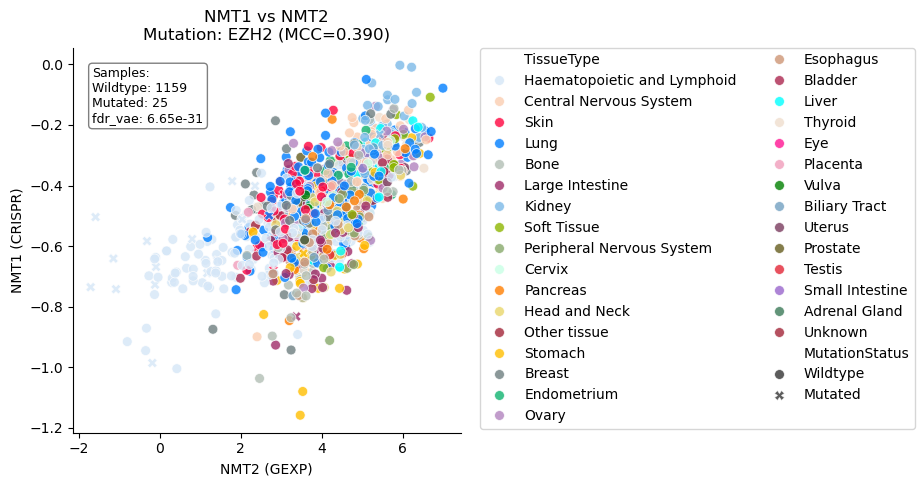

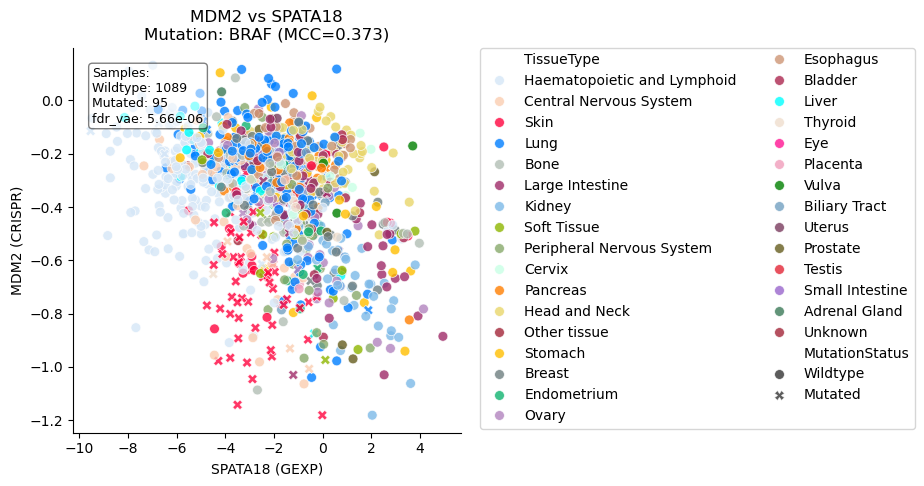

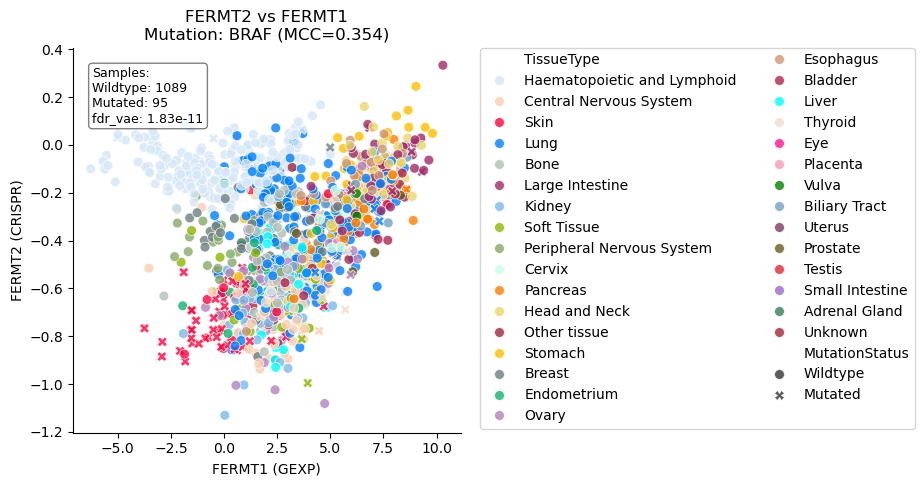

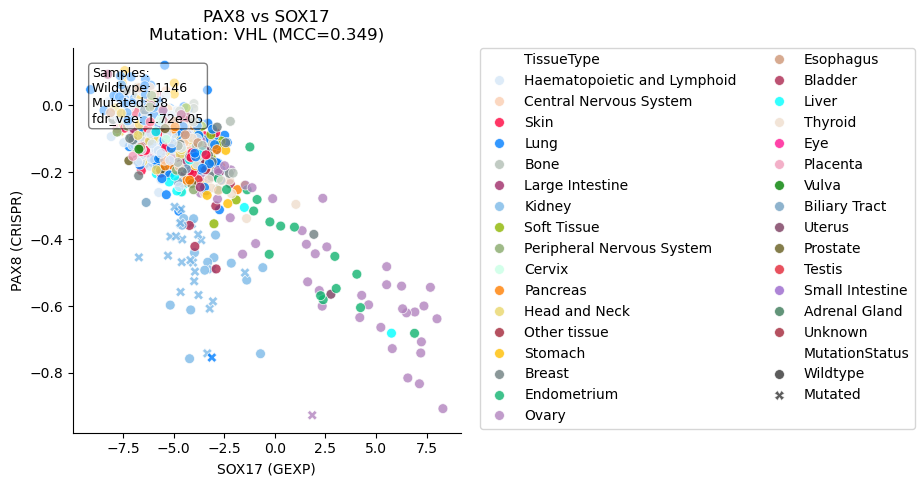

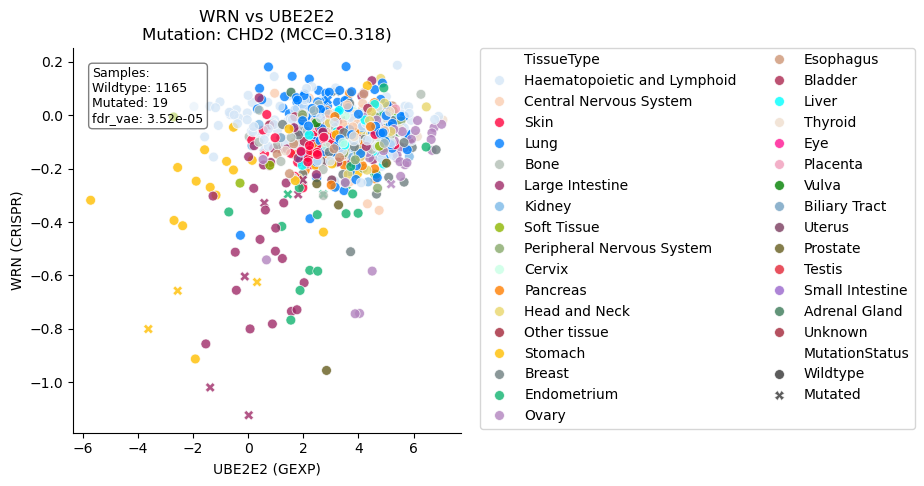

In [170]:
for i in range(10):
    plot_scatter_for_row(
        mcc_melt_df_filtered.iloc[i],
        gexp_df,
        cas9_df,
        mutations_measured,
        tissue_map,
        PALETTE_TTYPE,
    )
    plt.show()  # Add this line to display the plot in the notebook


## 2025 mutations


In [11]:
timestamp = "20250508_160635"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [12]:
mutations_measured = (
    pd.read_csv(f"{data_folder}/mutations_summary_20250318.csv", index_col=0)
    .assign(value=1)
    .query("cancer_driver == True")
)
mutations_measured = pd.pivot_table(
    mutations_measured,
    index="model_id",
    columns="gene_symbol",
    values="value",
    aggfunc="first",
    fill_value=0,
)

In [13]:
mutations_measured.head()

gene_symbol  ABCB1  ABI1  ABL1  ABL2  ACVR1  ACVR2A  AFF1  AFF3  AJUBA  AKT1  \
model_id                                                                       
SIDM00001        0     0     0     0      0       0     0     0      0     0   
SIDM00002        0     0     0     0      0       0     0     0      0     0   
SIDM00003        0     0     0     0      0       0     0     0      0     0   
SIDM00006        0     0     0     0      0       0     0     0      0     0   
SIDM00007        0     0     0     0      0       0     0     0      0     0   

gene_symbol  AKT2  AKT3  ALB  ALK  AMER1  ...  ZFP36L1  ZFX  ZNF165  ZNF208  \
model_id                                  ...                                 
SIDM00001       0     0    0    0      0  ...        0    0       0       0   
SIDM00002       0     0    0    0      0  ...        0    0       0       0   
SIDM00003       0     0    0    0      0  ...        0    0       0       0   
SIDM00006       0     0    0    0      0  ...        0    0       0       0   
SIDM00007       0     0    0    0      0  ...        0    0       0       0   

gene_symbol  ZNF331  ZNF429  ZNF521  ZNF626  ZNF680  ZNF721  ZNF814  ZNF93  \
model_id                                                                     
SIDM00001         0       0       0       0       0       0       0      0   
SIDM00002         0       0       0       0       0       0       0      0   
SIDM00003         0       0       0       0       0       0       0      0   
SIDM00006         0       0       0       0       0       0       0      0   
SIDM00007         0       0       0       0       0       0       0      0   

gene_symbol  ZNRF3  ZRSR2  ZXDB  
model_id                         
SIDM00001        0      0     0  
SIDM00002        0      0     0  
SIDM00003        0      0     0  
SIDM00006        0      0     0  
SIDM00007        0      0     0  

[5 rows x 607 columns]

In [14]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
gexp_measured = gexp_measured[gexp_measured.index.isin(gexp_df.index)]

In [15]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap24Q4/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=samplesheet.reset_index().groupby("BROAD_ID").first()["model_id"]
)
cas9_measured = cas9_measured[cas9_measured.index.isin(cas9_df.index)]

In [16]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))

In [17]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [18]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_remove_latent_n3_no_tissue_standardizedTrue_annot.csv.gz"
)

In [72]:
df_res_vae_annot.query("`y_id` == 'SOX10' and `x_id` == 'ADAMTSL1'")

y_id      x_id  n_orig  beta_orig  lr_orig  covs_orig  pval_orig  \
414356  SOX10  ADAMTSL1   923.0    0.09212  9.33008      208.0   0.002254   

        fdr_orig   n_vae  beta_vae    lr_vae  covs_vae  pval_vae   fdr_vae  \
414356  0.265256  1523.0   0.08905  15.76162     211.0  0.000072  0.052275   

        skew_orig  skew_mosa               target_detailed target  entropy  
414356   -3.76972   -3.47653  No link; Gene not in network      -  0.79088

In [75]:
df_res_vae_annot_filtered = df_res_vae_annot.query("entropy > 0.5")
df_res_vae_annot_filtered_top = df_res_vae_annot_filtered.query("fdr_vae < 0.001 and beta_vae > 0")

In [111]:
df_res_vae_annot_filtered_top

y_id    x_id  n_orig  beta_orig    lr_orig  covs_orig  \
0       FAM50A  FAM50B   923.0    0.75825  775.49438      208.0   
1        DDX3X   DDX3Y   923.0    0.70104  628.13085      208.0   
2        DDX3X   USP9Y   923.0    0.66805  569.93911      208.0   
3        DDX3X     UTY   923.0    0.67039  566.34511      208.0   
4       EIF1AX  EIF1AY   923.0    0.69643  563.47514      208.0   
...        ...     ...     ...        ...        ...        ...   
424662   DTYMK    SSPN   923.0    0.09748    7.28477      208.0   
427485    CDS2   BSPRY   923.0    0.15498    9.76961      208.0   
596619   PAICS    GJA1   923.0    0.09293    7.27058      208.0   
728686    TFRC    GJA1   923.0    0.09599    6.52759      208.0   
753046    CDH2   PTK2B   923.0    0.13606    7.19572      208.0   

            pval_orig       fdr_orig   n_vae  beta_vae     lr_vae  covs_vae  \
0       1.148490e-170  1.975632e-166  1523.0   0.62305  846.16667     211.0   
1       1.274517e-138  2.192424e-134  1523.0   0.54253  592.67442     211.0   
2       5.788442e-126  9.957278e-122  1523.0   0.50986  522.08826     211.0   
3       3.502334e-125  6.024714e-121  1523.0   0.50949  523.46762     211.0   
4       1.474560e-124  2.536539e-120  1523.0   0.54443  528.78237     211.0   
...               ...            ...     ...       ...        ...       ...   
424662   6.954145e-03   2.677355e-01  1523.0   0.13540   24.62452     211.0   
427485   1.774200e-03   2.683876e-01  1523.0   0.20703   34.13940     211.0   
596619   7.009323e-03   3.049655e-01  1523.0   0.12233   24.15479     211.0   
728686   1.062137e-02   3.286129e-01  1523.0   0.13494   24.43280     211.0   
753046   7.307761e-03   3.325611e-01  1523.0   0.19126   25.16090     211.0   

             pval_vae        fdr_vae  skew_orig  skew_mosa  \
0       4.953857e-186  1.802213e-182   -0.62729   -0.38142   
1       6.564286e-131  2.388087e-127    0.54274   -0.18181   
2       1.486670e-115  5.408505e-112    0.54274   -0.18181   
3       7.449375e-116  2.710083e-112    0.54274   -0.18181   
4       5.198192e-117  1.891102e-113    0.61340   -0.24279   
...               ...            ...        ...        ...   
424662   6.965974e-07   6.335554e-04    0.39834    0.41001   
427485   5.130193e-09   1.866364e-05   -1.00569   -0.35216   
596619   8.889463e-07   1.796659e-04   -0.69583   -0.59475   
728686   7.694749e-07   1.646676e-04   -0.28356   -0.23539   
753046   5.274073e-07   9.593539e-04   -1.74140   -0.51448   

                       target_detailed target  entropy  
0       No link; CRISPR not in network      -  0.82245  
1                                    3      3  0.83160  
2                                    3      3  0.83160  
3                                    3      3  0.83160  
4                                    1      1  0.83172  
...                                ...    ...      ...  
424662                              5+     5+  0.83166  
427485    No link; Gene not in network      -  0.72541  
596619                              5+     5+  0.81684  
728686                               3      3  0.82267  
753046                               2      2  0.68129  

[867 rows x 19 columns]

In [76]:
df_res_vae_annot_filtered_top.shape

(867, 19)

In [77]:
CRISPR_THRESHOLD = -0.5
GEXP_THRESHOLD = 0

In [78]:
sl_binary_matrix = make_sl_binary_matrix(
    gexp_df, cas9_df, df_res_vae_annot_filtered_top
)
sl_binary_matrix_measured = make_sl_binary_matrix(
    gexp_measured, cas9_measured, df_res_vae_annot_filtered_top
)

In [79]:
sl_binary_matrix

FAM50A:FAM50B  DDX3X:DDX3Y  DDX3X:USP9Y  DDX3X:UTY  EIF1AX:EIF1AY  \
SIDM00001              1            0            0          0              0   
SIDM00003              0            0            0          0              1   
SIDM00005              0            1            1          1              1   
SIDM00006              0            1            1          1              1   
SIDM00007              0            1            1          1              1   
...                  ...          ...          ...        ...            ...   
SIDM01979              0            1            1          1              1   
SIDM01980              0            1            1          1              1   
SIDM01981              0            1            1          1              1   
SIDM01983              0            0            0          0              1   
SIDM01985              0            1            1          1              1   

           DDX3X:KDM5D  RPP25L:RPP25  DDX3X:EIF1AY  EIF1AX:KDM5D  DDX3X:PRKY  \
SIDM00001            0             0             0             0           0   
SIDM00003            0             0             0             1           0   
SIDM00005            1             0             1             1           1   
SIDM00006            1             0             1             1           1   
SIDM00007            1             0             1             1           1   
...                ...           ...           ...           ...         ...   
SIDM01979            1             0             1             1           1   
SIDM01980            1             0             1             1           1   
SIDM01981            1             0             1             1           1   
SIDM01983            0             0             0             0           0   
SIDM01985            1             0             1             1           1   

           DDX3X:ZFY  EIF1AX:DDX3Y  EIF1AX:UTY  DDX3X:RPS4Y1  EIF1AX:USP9Y  \
SIDM00001          0             0           0             0             0   
SIDM00003          0             1           1             0             1   
SIDM00005          1             1           1             1             1   
SIDM00006          1             1           1             0             1   
SIDM00007          1             1           1             1             1   
...              ...           ...         ...           ...           ...   
SIDM01979          1             1           1             1             1   
SIDM01980          1             1           1             0             1   
SIDM01981          1             1           1             1             1   
SIDM01983          0             0           1             0             1   
SIDM01985          1             1           1             1             1   

           ...  ZNF217:CLDN12  CHMP4B:CRB3  CSF3:BICC1  PGM3:COL4A6  \
SIDM00001  ...              0            0           0            0   
SIDM00003  ...              0            1           0            0   
SIDM00005  ...              0            0           0            0   
SIDM00006  ...              0            1           0            0   
SIDM00007  ...              0            1           0            0   
...        ...            ...          ...         ...          ...   
SIDM01979  ...              0            1           0            0   
SIDM01980  ...              0            0           0            0   
SIDM01981  ...              0            0           0            0   
SIDM01983  ...              0            1           0            0   
SIDM01985  ...              0            0           0            0   

           ELMO2:COBL  CHMP4B:TMEM102  GFPT1:GFPT2  FERMT2:TMEM238  PFAS:GJA1  \
SIDM00001           0               0            1               0          1   
SIDM00003           0               0            0               1          0   
SIDM00005           0               0            0      

In [80]:
# Filter mutations to only include columns with more than 50 mutations
mutations_measured_filtered = mutations_measured.loc[:, mutations_measured.sum() > 20]

In [81]:
mutations_measured_filtered

gene_symbol  ACVR2A  APC  ARHGAP35  ARHGAP5  ARID1A  ARID1B  ARID2  ASXL1  \
model_id                                                                    
SIDM00001         0    0         0        0       0       0      0      0   
SIDM00002         0    0         0        0       0       0      0      0   
SIDM00003         0    0         0        0       0       0      0      0   
SIDM00006         0    0         0        0       0       0      0      0   
SIDM00007         0    0         0        0       0       0      0      0   
...             ...  ...       ...      ...     ...     ...    ...    ...   
SIDM02097         0    0         0        0       0       0      0      0   
SIDM02098         0    0         0        0       0       0      0      0   
SIDM02099         0    0         0        0       0       0      0      0   
SIDM02100         0    0         0        0       0       0      0      0   
SIDM02101         0    0         0        0       0       0      0      0   

gene_symbol  ASXL2  ATF7IP  ATM  ATR  B2M  BAP1  BAX  ...  STAT5B  STK11  \
model_id                                              ...                  
SIDM00001        0       0    0    0    0     0    0  ...       0      0   
SIDM00002        0       0    0    0    0     0    0  ...       0      0   
SIDM00003        0       0    0    0    0     0    0  ...       0      0   
SIDM00006        0       0    0    0    0     0    0  ...       0      0   
SIDM00007        0       0    0    0    0     0    0  ...       0      0   
...            ...     ...  ...  ...  ...   ...  ...  ...     ...    ...   
SIDM02097        0       0    0    0    0     0    0  ...       0      0   
SIDM02098        0       0    0    0    0     1    0  ...       0      0   
SIDM02099        0       0    0    0    0     0    0  ...       0      0   
SIDM02100        0       0    0    0    0     0    0  ...       0      0   
SIDM02101        0       0    0    0    0     0    0  ...       0      0   

gene_symbol  TET2  TGFBR2  TP53  TRRAP  TSC2  UBR5  USP9X  VHL  WNK2  WNK4  \
model_id                                                                     
SIDM00001       0       0     1      0     0     0      0    0     0     0   
SIDM00002       0       0     1      0     0     0      0    0     0     0   
SIDM00003       0       0     1      0     0     0      0    0     0     0   
SIDM00006       0       0     1      0     0     0      0    0     0     0   
SIDM00007       0       0     1      0     0     0      0    0     0     0   
...           ...     ...   ...    ...   ...   ...    ...  ...   ...   ...   
SIDM02097       0       0     0      0     0     0      0    0     0     0   
SIDM02098       0       0     0      0     0     0      0    0     0     0   
SIDM02099       0       0     0      0     0     0      0    0     0     0   
SIDM02100       0       0     0      0     0     0      0    0     0     0   
SIDM02101       0       0     0      0     0     0      0    0     0     0   

gene_symbol  WRN  ZFHX3  ZNF208  
model_id                         
SIDM00001      0      0       0  
SIDM00002      0      0       0  
SIDM00003      0      1       0  
SIDM00006      0      0       0  
SIDM00007      0      1       0  
...          ...    ...     ...  
SIDM02097      0      0       0  
SIDM02098      0      0       0  
SIDM02099      0      0       0  
SIDM02100      0      0       0  
SIDM02101      0      0       0  

[1417 rows x 139 columns]

In [82]:
mcc_df = pairwise_mcc(sl_binary_matrix, mutations_measured_filtered)
mcc_df_measured = pairwise_mcc(sl_binary_matrix_measured, mutations_measured_filtered)

MCC pairs:   0%|          | 0/120513 [00:00<?, ?it/s]

MCC pairs:   0%|          | 0/120513 [00:00<?, ?it/s]

In [83]:
mcc_df

gene_symbol      ACVR2A       APC  ARHGAP35   ARHGAP5    ARID1A    ARID1B  \
FAM50A:FAM50B  0.116978  0.188752  0.033115 -0.010965  0.075876  0.043271   
DDX3X:DDX3Y    0.107361  0.065568  0.124774  0.075913  0.149811  0.079557   
DDX3X:USP9Y    0.104711  0.114547  0.104791  0.063220  0.114394  0.065107   
DDX3X:UTY      0.102883  0.145839  0.089208  0.063719  0.104663  0.057331   
EIF1AX:EIF1AY  0.043223  0.066030  0.032288  0.046992  0.048418  0.021793   
...                 ...       ...       ...       ...       ...       ...   
DTYMK:SSPN     0.178304  0.125502  0.094392  0.038224  0.124137  0.096080   
CDS2:BSPRY    -0.016489 -0.017754 -0.010482 -0.008867  0.020176 -0.011895   
PAICS:GJA1     0.089035  0.058231 -0.013591  0.007948  0.020583 -0.003895   
TFRC:GJA1      0.047721  0.113589 -0.037681  0.000914 -0.015263  0.002523   
CDH2:PTK2B          NaN       NaN       NaN       NaN       NaN       NaN   

gene_symbol       ARID2     ASXL1     ASXL2    ATF7IP       ATM       ATR  \
FAM50A:FAM50B  0.051576  0.123059  0.051905  0.042695  0.038836  0.077158   
DDX3X:DDX3Y    0.068337  0.001664  0.047947  0.053155  0.081520  0.027346   
DDX3X:USP9Y    0.060558  0.019226  0.035579  0.074549  0.067643  0.014140   
DDX3X:UTY      0.050947 -0.001984  0.021759  0.079417  0.046195 -0.000334   
EIF1AX:EIF1AY  0.030711 -0.053093  0.013066  0.054708  0.055548 -0.016852   
...                 ...       ...       ...       ...       ...       ...   
DTYMK:SSPN     0.064502  0.150656  0.066352  0.036379  0.033150  0.059070   
CDS2:BSPRY    -0.012638 -0.013345 -0.008867 -0.011309 -0.013855 -0.009114   
PAICS:GJA1     0.023700  0.036784  0.060034  0.031515  0.040176  0.038224   
TFRC:GJA1      0.056417  0.021163  0.062786  0.012730  0.032341  0.041941   
CDH2:PTK2B          NaN       NaN       NaN       NaN       NaN       NaN   

gene_symbol         B2M      BAP1       BAX  ...    STAT5B     STK11  \
FAM50A:FAM50B  0.083571 -0.050713  0.203714  ...  0.089129 -0.055886   
DDX3X:DDX3Y    0.090816 -0.062643  0.044427  ...  0.098146  0.089249   
DDX3X:USP9Y    0.060726 -0.064017  0.028428  ...  0.081144  0.121760   
DDX3X:UTY      0.045316 -0.067227  0.034461  ...  0.091687  0.133765   
EIF1AX:EIF1AY  0.012295 -0.040906 -0.027419  ...  0.070827  0.086111   
...                 ...       ...       ...  ...       ...       ...   
DTYMK:SSPN     0.095945 -0.032538  0.219532  ...  0.141444 -0.007115   
CDS2:BSPRY    -0.010045 -0.009590 -0.016197  ... -0.009820 -0.014829   
PAICS:GJA1     0.038078 -0.050418  0.163247  ...  0.026281 -0.028187   
TFRC:GJA1      0.009416 -0.068315  0.105919  ... -0.000545 -0.032784   
CDH2:PTK2B          NaN       NaN       NaN  ...       NaN       NaN   

gene_symbol        TET2    TGFBR2      TP53     TRRAP      TSC2      UBR5  \
FAM50A:FAM50B  0.116113 -0.007154 -0.057403  0.041181  0.091932  0.069615   
DDX3X:DDX3Y   -0.032025  0.042822  0.112252  0.053646  0.035273  0.103164   
DDX3X:USP9Y   -0.058698  0.069034  0.114112  0.033899  0.029189  0.086743   
DDX3X:UTY     -0.074432  0.081638  0.137006  0.051499  0.049478  0.091299   
EIF1AX:EIF1AY -0.125803  0.049330  0.119203  0.036852  0.044583  0.049785   
...                 ...       ...       ...       ...       ...       ...   
DTYMK:SSPN     0.132318  0.006790 -0.063963  0.088917  0.052392  0.101431   
CDS2:BSPRY     0.082947 -0.012084  0.024373 -0.013171 -0.010265 -0.014349   
PAICS:GJA1     0.099969  0.032341  0.000715  0.039579  0.049400  0.032405   
TFRC:GJA1      0.080925  0.022326 -0.031355  0.024334  0.032396  0.013450   
CDH2:PTK2B          NaN       NaN       NaN       NaN       NaN       NaN   

gene_symbol       USP9X       VHL      WNK2      WNK4       WRN     ZFHX3  \
FAM50A:FAM50B  0.022139 -0.086389  0.094990  0.092462  0.068429  0.040669   
DDX3X:DDX3Y    0.066978 -0.038665  0.066978  0.054577  0.035773  0.097839   
DDX3X:USP9Y    0.064103 -0.047001  0.051291  0.027598  0.039062  0.070819   
DDX3X:UTY      0.049465 -0.019895  0.036499  0.01328

In [84]:
mcc_df_measured

gene_symbol      ACVR2A       APC  ARHGAP35   ARHGAP5    ARID1A    ARID1B  \
FAM50A:FAM50B  0.066442  0.150252  0.054070  0.064857  0.086993  0.050456   
DDX3X:DDX3Y    0.037284  0.025649  0.065156  0.049608  0.078352  0.011627   
DDX3X:USP9Y    0.042456  0.046960  0.062530  0.047322  0.072546  0.008354   
DDX3X:UTY      0.050794  0.045804  0.061876  0.046752  0.078256  0.007536   
EIF1AX:EIF1AY  0.039302  0.026195  0.060572  0.045615  0.082523  0.005899   
...                 ...       ...       ...       ...       ...       ...   
DTYMK:SSPN     0.108040  0.093064  0.056099  0.051513  0.097184  0.073500   
CDS2:BSPRY    -0.077445 -0.080286 -0.033451 -0.018829 -0.017428  0.019382   
PAICS:GJA1     0.057081  0.085740 -0.001998 -0.002734  0.005470  0.025921   
TFRC:GJA1      0.048419  0.052379 -0.012554 -0.011874  0.015964  0.025566   
CDH2:PTK2B    -0.008029 -0.008818 -0.005014 -0.004365  0.097814 -0.006227   

gene_symbol       ARID2     ASXL1     ASXL2    ATF7IP       ATM       ATR  \
FAM50A:FAM50B  0.073220 -0.004356  0.010752 -0.005286  0.028528  0.057977   
DDX3X:DDX3Y    0.012008  0.010962 -0.008698 -0.007115  0.021564  0.017576   
DDX3X:USP9Y    0.008842  0.007483 -0.010921 -0.009879  0.017987  0.015434   
DDX3X:UTY      0.020260  0.006613 -0.011477  0.003318  0.017093  0.014899   
EIF1AX:EIF1AY  0.018680  0.004873 -0.012591 -0.025847  0.015306  0.013830   
...                 ...       ...       ...       ...       ...       ...   
DTYMK:SSPN     0.027923  0.068646  0.038953 -0.017548  0.048005  0.045628   
CDS2:BSPRY    -0.022007 -0.035842 -0.037737 -0.038493  0.016757 -0.034900   
PAICS:GJA1     0.017379  0.013466  0.022974 -0.008760 -0.047171 -0.038825   
TFRC:GJA1      0.032949  0.025504  0.012855 -0.002859 -0.046248 -0.024351   
CDH2:PTK2B    -0.006023 -0.006620 -0.004224 -0.005253 -0.006809 -0.004078   

gene_symbol         B2M      BAP1       BAX  ...    STAT5B     STK11  \
FAM50A:FAM50B  0.077079 -0.005017  0.068135  ...  0.077079 -0.010222   
DDX3X:DDX3Y    0.044437 -0.017844 -0.010001  ...  0.029571  0.043351   
DDX3X:USP9Y    0.041873 -0.019991 -0.004300  ...  0.027004  0.039778   
DDX3X:UTY      0.056103 -0.020529  0.014188  ...  0.026364  0.038886   
EIF1AX:EIF1AY  0.054830 -0.021607  0.002414  ...  0.025083  0.037104   
...                 ...       ...       ...  ...       ...       ...   
DTYMK:SSPN     0.112395  0.005546  0.123930  ...  0.095572  0.023350   
CDS2:BSPRY    -0.011413 -0.034900 -0.058604  ... -0.069522  0.016757   
PAICS:GJA1     0.057828  0.072775  0.093463  ...  0.057828 -0.019711   
TFRC:GJA1      0.026754  0.060487  0.072456  ...  0.062361 -0.033202   
CDH2:PTK2B    -0.004891 -0.004078 -0.007696  ... -0.004891 -0.006809   

gene_symbol        TET2    TGFBR2      TP53     TRRAP      TSC2      UBR5  \
FAM50A:FAM50B  0.078975  0.026705  0.006868 -0.025144  0.048964  0.101999   
DDX3X:DDX3Y   -0.035553 -0.006610  0.114402  0.043231 -0.014359  0.051691   
DDX3X:USP9Y   -0.037704 -0.009611  0.107699  0.040126 -0.017061  0.047927   
DDX3X:UTY     -0.038243 -0.010361  0.124590  0.039351 -0.017738  0.046988   
EIF1AX:EIF1AY -0.039325 -0.011864  0.130540  0.037804 -0.019093  0.045112   
...                 ...       ...       ...       ...       ...       ...   
DTYMK:SSPN     0.045628 -0.002624 -0.008116  0.088281  0.018453  0.103779   
CDS2:BSPRY     0.011251 -0.047620 -0.006404 -0.019470  0.019448 -0.047867   
PAICS:GJA1     0.028135  0.027791  0.027623 -0.010549 -0.005452  0.049498   
TFRC:GJA1      0.039277  0.029668  0.018530 -0.007743  0.017894  0.044225   
CDH2:PTK2B    -0.004078 -0.005704  0.022512 -0.005918 -0.005135 -0.007175   

gene_symbol       USP9X       VHL      WNK2      WNK4       WRN     ZFHX3  \
FAM50A:FAM50B -0.003050 -0.034212  0.112332  0.010752  0.036859 -0.002161   
DDX3X:DDX3Y   -0.031458 -0.032298 -0.000161  0.042657  0.007093  0.050549   
DDX3X:USP9Y   -0.033900 -0.035303 -0.002733  0.040443  0.004457  0.046692   
DDX3X:UTY     -0.003199 -0.036057 -0.003376  0.03989

In [85]:
mcc_df = mcc_df.dropna()
mcc_df_measured = mcc_df_measured.loc[mcc_df.index]

In [86]:
mcc_diff = mcc_df.max() - mcc_df_measured.max()
mcc_diff.sort_values(ascending=False)


gene_symbol
EZH2        0.157342
RB1         0.142831
POLE        0.135359
PRDM2       0.130034
ATF7IP      0.122777
              ...   
TRRAP      -0.090712
BAX        -0.091162
MCM3AP     -0.106864
SPEN       -0.114527
ARHGAP35   -0.119267
Length: 139, dtype: float64

In [87]:
mcc_diff_all = mcc_df.abs() - mcc_df_measured.abs()

Text(0.5, 9.444444444444438, 'Difference in Maximum MCC (MOSA - Measured)')

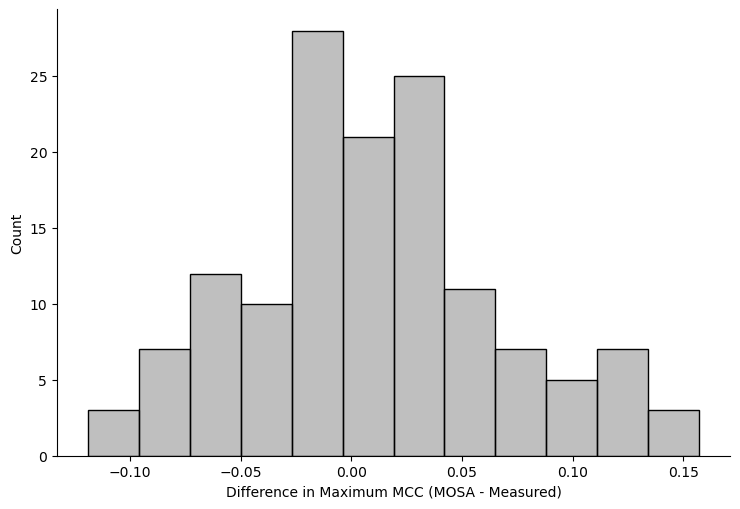

In [88]:
sns.displot(
    data=mcc_diff,
    kind="hist",
    fill=True,
    alpha=0.5,
    height=5,
    aspect=1.5,
    legend=True,
    color="grey",
)
plt.xlabel("Difference in Maximum MCC (MOSA - Measured)")

Text(0.5, 9.444444444444438, 'Difference in absolute MCC (MOSA - Measured)')

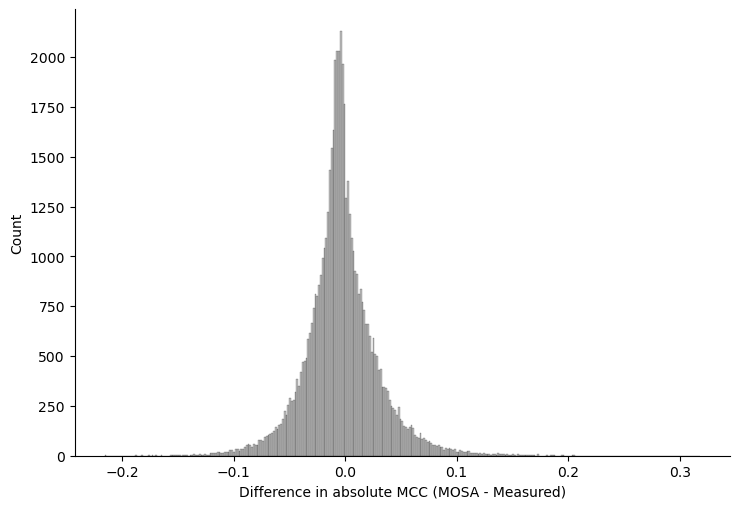

In [89]:
sns.displot(
    data=mcc_diff_all.stack(),
    kind="hist",
    fill=True,
    alpha=0.5,
    height=5,
    aspect=1.5,
    legend=True,
    color="grey",
)
plt.xlabel("Difference in absolute MCC (MOSA - Measured)")

/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 9.444444444444438, 'Maximum  MCC')

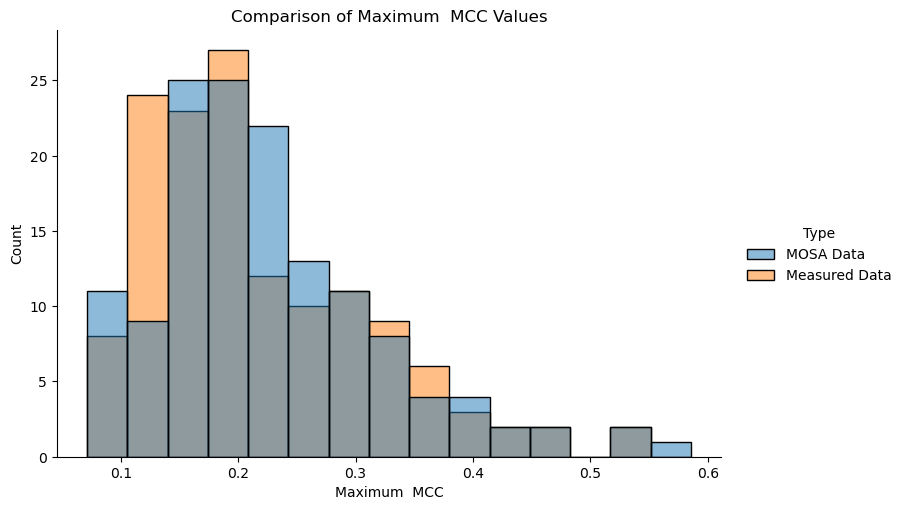

In [90]:
# Create a DataFrame to combine both distributions
combined_data = pd.DataFrame({
    'MCC': pd.concat([mcc_df.max(), mcc_df_measured.max()]),
    'Type': ['MOSA Data'] * len(mcc_df.max()) + ['Measured Data'] * len(mcc_df_measured.max())
})

# Plot both distributions in one figure
sns.displot(
    data=combined_data, 
    x='MCC', 
    hue='Type', 
    kind='hist', 
    fill=True, 
    alpha=0.5,
    height=5, 
    aspect=1.5,
    legend=True
)
plt.title('Comparison of Maximum  MCC Values')
plt.xlabel('Maximum  MCC')


/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/scai/anaconda3/envs/mosa/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 9.444444444444438, 'Minimum  MCC')

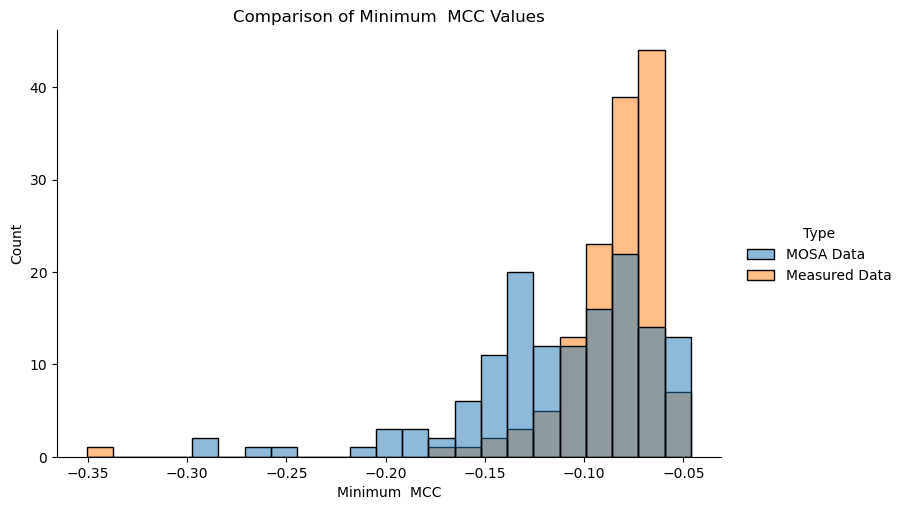

In [91]:
# Create a DataFrame to combine both distributions
combined_data = pd.DataFrame(
    {
        "MCC": pd.concat([mcc_df.min(), mcc_df_measured.min()]),
        "Type": ["MOSA Data"] * len(mcc_df.min())
        + ["Measured Data"] * len(mcc_df_measured.min()),
    }
)

# Plot both distributions in one figure
sns.displot(
    data=combined_data,
    x="MCC",
    hue="Type",
    kind="hist",
    fill=True,
    alpha=0.5,
    height=5,
    aspect=1.5,
    legend=True,
)
plt.title("Comparison of Minimum  MCC Values")
plt.xlabel("Minimum  MCC")

In [92]:
mcc_melt_df = mcc_df.reset_index().melt(
    id_vars="index", var_name="mut_col", value_name="mcc"
)
mcc_melt_df = mcc_melt_df.rename(columns={"index": "CRISPR:GEXP"})
mcc_melt_df.sort_values(by="mcc", ascending=False).round(5).to_csv(
    f"../reports/vae/crispr/{timestamp}_mcc_results.csv", index=False
)

In [93]:
mcc_melt_measured_df = mcc_df_measured.reset_index().melt(
    id_vars="index", var_name="mut_col", value_name="mcc"
)
mcc_melt_measured_df = mcc_melt_measured_df.rename(columns={"index": "CRISPR:GEXP"})
mcc_melt_measured_df.sort_values(by="mcc", ascending=False).round(5).to_csv(
    f"../reports/vae/crispr/{timestamp}_mcc_results_measured.csv", index=False
)

In [22]:
mcc_melt_df['crispr_gene'] = mcc_melt_df['CRISPR:GEXP'].str.split(':').str[0]
mcc_melt_df['rna_gene'] = mcc_melt_df['CRISPR:GEXP'].str.split(':').str[1]
mcc_melt_df.rename(columns={"mut_col": "Mutation"}, inplace=True)
mcc_melt_df = mcc_melt_df[["CRISPR:GEXP", "crispr_gene", "rna_gene", "Mutation", "mcc"]]

In [19]:
mcc_melt_df = pd.read_csv(f"../reports/vae/crispr/{timestamp}_mcc_results.csv")
mcc_melt_measured_df = pd.read_csv(f"../reports/vae/crispr/{timestamp}_mcc_results_measured.csv")

In [20]:
mcc_melt_df

CRISPR:GEXP mut_col      mcc
0      FAM50A:FAM50B  ACVR2A  0.11698
1        DDX3X:DDX3Y  ACVR2A  0.10736
2        DDX3X:USP9Y  ACVR2A  0.10471
3          DDX3X:UTY  ACVR2A  0.10288
4      EIF1AX:EIF1AY  ACVR2A  0.04322
...              ...     ...      ...
56012    ITGAV:PRRG2  ZNF208 -0.03436
56013     DTYMK:SSPN  ZNF208  0.07486
56014     CDS2:BSPRY  ZNF208  0.06146
56015     PAICS:GJA1  ZNF208  0.04851
56016      TFRC:GJA1  ZNF208  0.04921

[56017 rows x 3 columns]

In [26]:
mcc_melt_df_filtered = mcc_melt_df.query("mcc > 0.3").sort_values(
    "mcc", ascending=False
)
mcc_melt_df_filtered_measured = mcc_melt_measured_df.query("mcc > 0.3").sort_values(
    "mcc", ascending=False
)


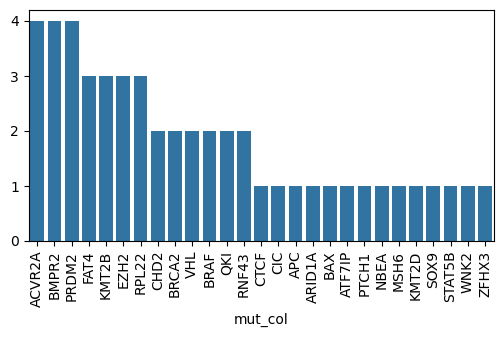

In [110]:
mut_counts = mcc_melt_df_filtered.groupby("mut_col").size().sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.barplot(x=mut_counts.index, y=mut_counts.values)
plt.xticks(rotation=90)
plt.show()

In [28]:
mcc_melt_df_filtered[mcc_melt_df_filtered['Mutation'] == 'BRAF']

CRISPR:GEXP crispr_gene rna_gene Mutation      mcc
8444   SOX10:OCIAD2       SOX10   OCIAD2     BRAF  0.45473
8195  FERMT2:FERMT1      FERMT2   FERMT1     BRAF  0.30204

In [98]:
mcc_melt_df_filtered.shape

(50, 3)

In [99]:
mcc_melt_df_filtered_measured.groupby("Mutation").size().sort_values(ascending=False)

mut_col
ACVR2A    3
BMPR2     3
BAX       3
RPL22     3
KMT2B     3
CHD2      2
ARID1A    2
MSH6      2
PRDM2     2
FAT4      2
RNF43     2
VHL       2
HNF1A     1
CRTC1     1
BRAF      1
APC       1
CTCF      1
MCM3AP    1
KMT2D     1
QKI       1
PTPRK     1
NCOR1     1
SPEN      1
STAT5B    1
TP53      1
UBR5      1
WNK2      1
dtype: int64

In [100]:
# Split CRISPR:GEXP into y_id and x_id
mcc_melt_df_filtered[['y_id', 'x_id']] = mcc_melt_df_filtered['CRISPR:GEXP'].str.split(':', expand=True)

# Create a mapping dictionary from df_res_vae_annot_filtered_top
fdr_map = {}
for _, row in df_res_vae_annot_filtered_top.iterrows():
    key = f"{row['y_id']}:{row['x_id']}"
    fdr_map[key] = row['fdr_vae']

# Map the fdr_vae values
mcc_melt_df_filtered['fdr_vae'] = mcc_melt_df_filtered['CRISPR:GEXP'].map(fdr_map)
mcc_melt_df_filtered = mcc_melt_df_filtered.drop(columns=["y_id", "x_id"])

In [101]:
mcc_melt_df_filtered_measured[["y_id", "x_id"]] = mcc_melt_df_filtered_measured[
    "CRISPR:GEXP"
].str.split(":", expand=True)

# Create a mapping dictionary from df_res_vae_annot_filtered_top
fdr_map = {}
for _, row in df_res_vae_annot_filtered_top.iterrows():
    key = f"{row['y_id']}:{row['x_id']}"
    fdr_map[key] = row["fdr_vae"]

# Map the fdr_vae values
mcc_melt_df_filtered_measured["fdr_vae"] = mcc_melt_df_filtered_measured[
    "CRISPR:GEXP"
].map(fdr_map)
mcc_melt_df_filtered_measured = mcc_melt_df_filtered_measured.drop(
    columns=["y_id", "x_id"]
)

In [102]:
mcc_melt_df_filtered_measured

CRISPR:GEXP mut_col      mcc       fdr_vae
28475     WRN:KRT6C   KMT2B  0.53142  2.214219e-06
46610     WRN:KRT6C   RPL22  0.53131  2.214219e-06
265       WRN:KRT6C  ACVR2A  0.47711  2.214219e-06
5907      WRN:KRT6C     BAX  0.44969  2.214219e-06
46593    WRN:GPR176   RPL22  0.43718  1.509582e-04
28305    WRN:UBE2E2   KMT2B  0.42847  2.585709e-08
50237     WRN:KRT6C  STAT5B  0.42483  2.214219e-06
46440    WRN:UBE2E2   RPL22  0.42050  2.585709e-08
28458    WRN:GPR176   KMT2B  0.41885  1.509582e-04
22260    WRN:UBE2E2    FAT4  0.41538  2.585709e-08
22413    WRN:GPR176    FAT4  0.41058  1.509582e-04
766    CTNNB1:TCEA2     APC  0.40601  3.953313e-04
7905     WRN:GPR176   BMPR2  0.40382  1.509582e-04
7752     WRN:UBE2E2   BMPR2  0.38753  2.585709e-08
95       WRN:UBE2E2  ACVR2A  0.38679  2.585709e-08
53987  PAX8:TSPOAP1     VHL  0.38214  3.141835e-04
1877      WRN:KRT6C  ARID1A  0.36956  2.214219e-06
8444   SOX10:OCIAD2    BRAF  0.36892  3.145829e-04
14773     WRN:KRT6C    CTCF  0.36431  2.214219e-06
7922      WRN:KRT6C   BMPR2  0.35939  2.214219e-06
43772    WRN:GPR176   PTPRK  0.35369  1.509582e-04
12588    WRN:UBE2E2    CHD2  0.35118  2.585709e-08
54267     WRN:KRT6C    WNK2  0.34897  2.214219e-06
51681   RPL22:EDA2R    TP53  0.34493  2.079533e-06
46207     WRN:KRT6C   RNF43  0.34128  2.214219e-06
32891    WRN:GPR176    MSH6  0.34026  1.509582e-04
248      WRN:GPR176  ACVR2A  0.34026  1.509582e-04
46037    WRN:UBE2E2   RNF43  0.33302  2.585709e-08
53751   PAX8:TMEM40     VHL  0.33235  9.417088e-04
41371     WRN:KRT6C   PRDM2  0.32511  2.214219e-06
14370     WRN:KRT6C   CRTC1  0.32170  2.214219e-06
41201    WRN:UBE2E2   PRDM2  0.32064  2.585709e-08
49431     WRN:KRT6C    SPEN  0.31814  2.214219e-06
5737     WRN:UBE2E2     BAX  0.31776  2.585709e-08
5890     WRN:GPR176     BAX  0.31726  1.509582e-04
29281     WRN:KRT6C   KMT2D  0.31563  2.214219e-06
44425    WRN:UBE2E2     QKI  0.31139  2.585709e-08
34753    WRN:UBE2E2   NCOR1  0.31139  2.585709e-08
12741    WRN:GPR176    CHD2  0.31122  1.509582e-04
32908     WRN:KRT6C    MSH6  0.30945  2.214219e-06
1707     WRN:UBE2E2  ARID1A  0.30925  2.585709e-08
26040    WRN:GPR176   HNF1A  0.30106  1.509582e-04
53041    WRN:GPR176    UBR5  0.30090  1.509582e-04
30893     WRN:KRT6C  MCM3AP  0.30066  2.214219e-06

In [103]:
mcc_melt_df_filtered

CRISPR:GEXP mut_col      mcc       fdr_vae
46610      WRN:KRT6C   RPL22  0.58542  2.214219e-06
265        WRN:KRT6C  ACVR2A  0.53221  2.214219e-06
7922       WRN:KRT6C   BMPR2  0.52365  2.214219e-06
7905      WRN:GPR176   BMPR2  0.49406  1.509582e-04
248       WRN:GPR176  ACVR2A  0.47483  1.509582e-04
46593     WRN:GPR176   RPL22  0.46639  1.509582e-04
41354     WRN:GPR176   PRDM2  0.45514  1.509582e-04
8444    SOX10:OCIAD2    BRAF  0.45473  3.145829e-04
28475      WRN:KRT6C   KMT2B  0.44134  2.214219e-06
22413     WRN:GPR176    FAT4  0.41864  1.509582e-04
22260     WRN:UBE2E2    FAT4  0.40472  2.585709e-08
41371      WRN:KRT6C   PRDM2  0.40015  2.214219e-06
12588     WRN:UBE2E2    CHD2  0.39720  2.585709e-08
20580      NMT1:NMT2    EZH2  0.39642  7.825689e-37
766     CTNNB1:TCEA2     APC  0.39578  3.953313e-04
9131       WRN:KRT6C   BRCA2  0.39375  2.214219e-06
9114      WRN:GPR176   BRCA2  0.38175  1.509582e-04
8020    CTNNB1:TCEA2   BMPR2  0.37581  3.953313e-04
22430      WRN:KRT6C    FAT4  0.36350  2.214219e-06
46207      WRN:KRT6C   RNF43  0.36278  2.214219e-06
12741     WRN:GPR176    CHD2  0.35866  1.509582e-04
5907       WRN:KRT6C     BAX  0.35853  2.214219e-06
20617      RHOA:RHOB    EZH2  0.35679  2.987051e-10
44595      WRN:KRT6C     QKI  0.35606  2.214219e-06
50237      WRN:KRT6C  STAT5B  0.35606  2.214219e-06
363     CTNNB1:TCEA2  ACVR2A  0.35481  3.953313e-04
46440     WRN:UBE2E2   RPL22  0.34899  2.585709e-08
95        WRN:UBE2E2  ACVR2A  0.33886  2.585709e-08
14773      WRN:KRT6C    CTCF  0.33776  2.214219e-06
34117      WRN:KRT6C    NBEA  0.33753  2.214219e-06
46190     WRN:GPR176   RNF43  0.33473  1.509582e-04
53987   PAX8:TSPOAP1     VHL  0.33027  3.141835e-04
32908      WRN:KRT6C    MSH6  0.32904  2.214219e-06
28305     WRN:UBE2E2   KMT2B  0.32635  2.585709e-08
20570    TTC7A:TTC7B    EZH2  0.32510  1.609074e-73
54267      WRN:KRT6C    WNK2  0.32239  2.214219e-06
3990    CTNNB1:TCEA2  ATF7IP  0.32215  3.953313e-04
41201     WRN:UBE2E2   PRDM2  0.31492  2.585709e-08
1877       WRN:KRT6C  ARID1A  0.31421  2.214219e-06
28458     WRN:GPR176   KMT2B  0.31363  1.509582e-04
41604     WRN:UBE2E2   PTCH1  0.31263  2.585709e-08
7752      WRN:UBE2E2   BMPR2  0.31263  2.585709e-08
44425     WRN:UBE2E2     QKI  0.31263  2.585709e-08
41469   CTNNB1:TCEA2   PRDM2  0.31015  3.953313e-04
29281      WRN:KRT6C   KMT2D  0.30975  2.214219e-06
55476      WRN:KRT6C   ZFHX3  0.30913  2.214219e-06
13187     SDHA:PTPRF     CIC  0.30612  6.297112e-04
49011     WRN:GPR176    SOX9  0.30569  1.509582e-04
53845     ITGAV:CDH3     VHL  0.30424  4.368788e-04
8195   FERMT2:FERMT1    BRAF  0.30204  1.235251e-05

In [33]:
mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'MDM2:SPATA18'")

CRISPR:GEXP mut_col      mcc
6092  MDM2:SPATA18    BRAF  0.35858

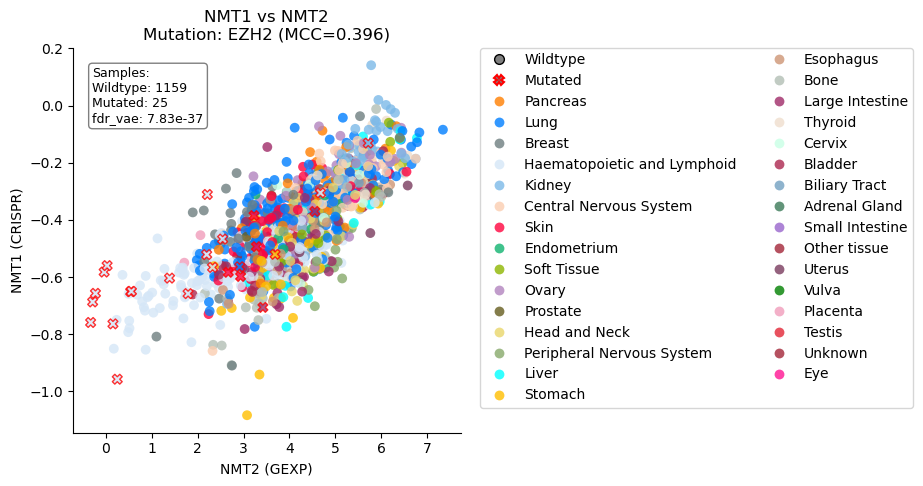

In [53]:
# Call the plotting function
fig = plot_scatter_for_row(
    mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'NMT1:NMT2'").iloc[0],
    gexp_df,
    cas9_df,
    mutations_measured,
    tissue_map,
    PALETTE_TTYPE,
)
plt.show()  # Add this line to display the plot in the notebook

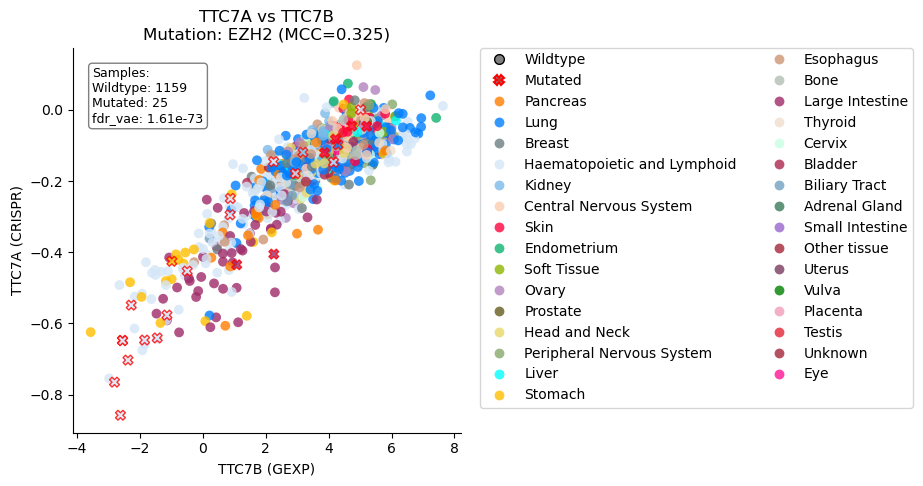

In [55]:
# Call the plotting function
fig = plot_scatter_for_row(
    mcc_melt_df_filtered.query("`CRISPR:GEXP` == 'TTC7A:TTC7B'").iloc[0],
    gexp_df,
    cas9_df,
    mutations_measured,
    tissue_map,
    PALETTE_TTYPE,
)
plt.show()  # Add this line to display the plot in the notebook

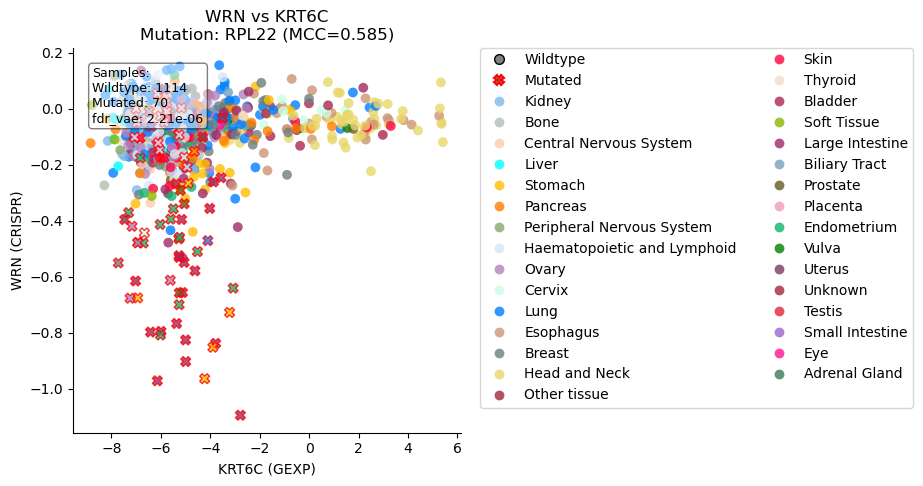

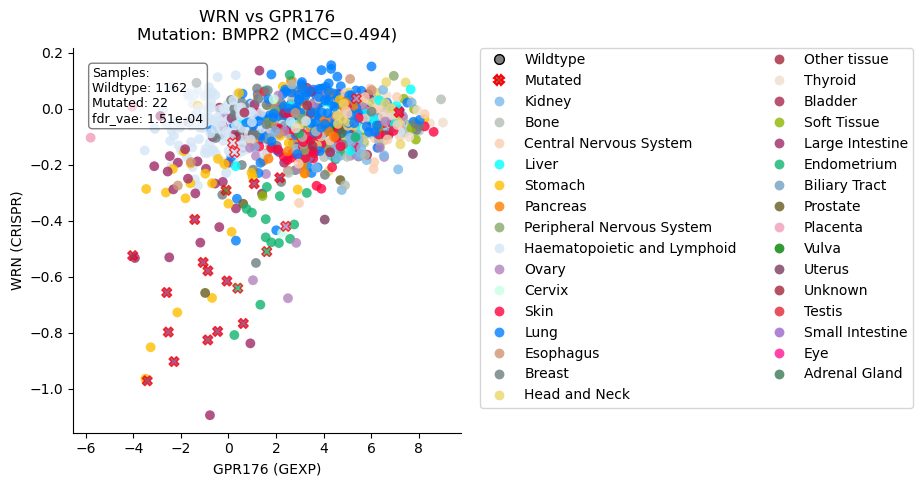

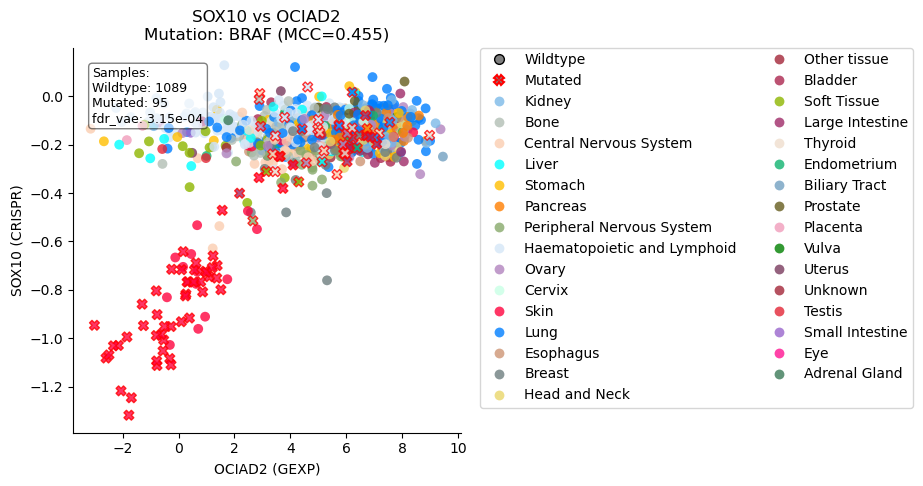

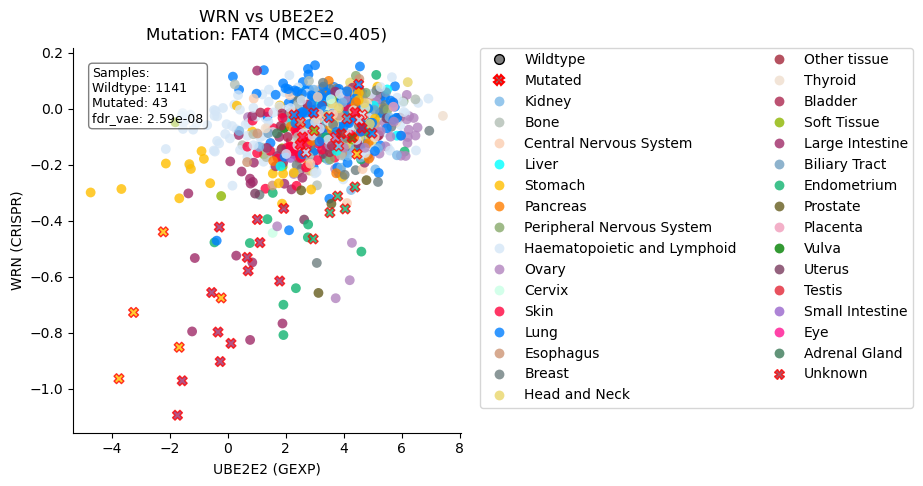

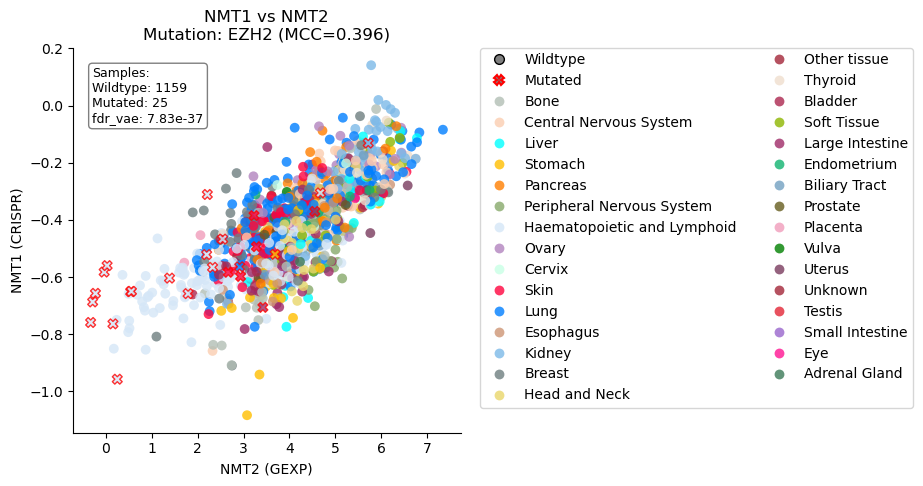

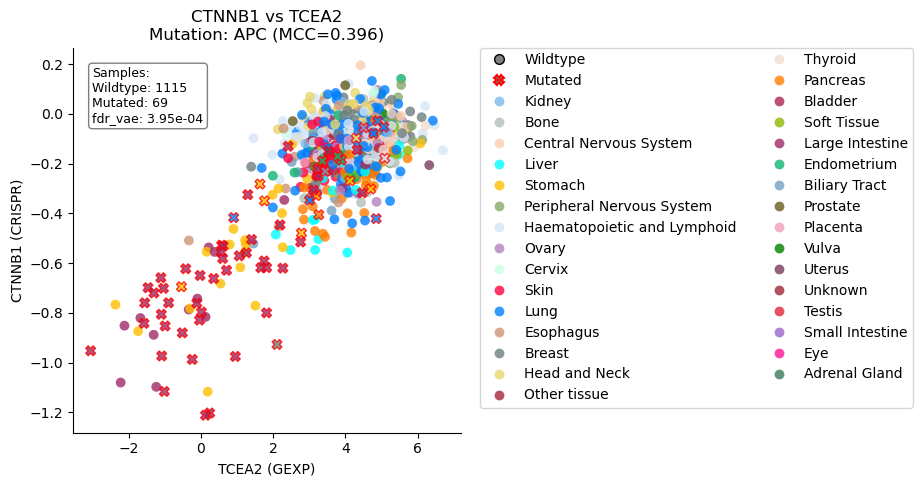

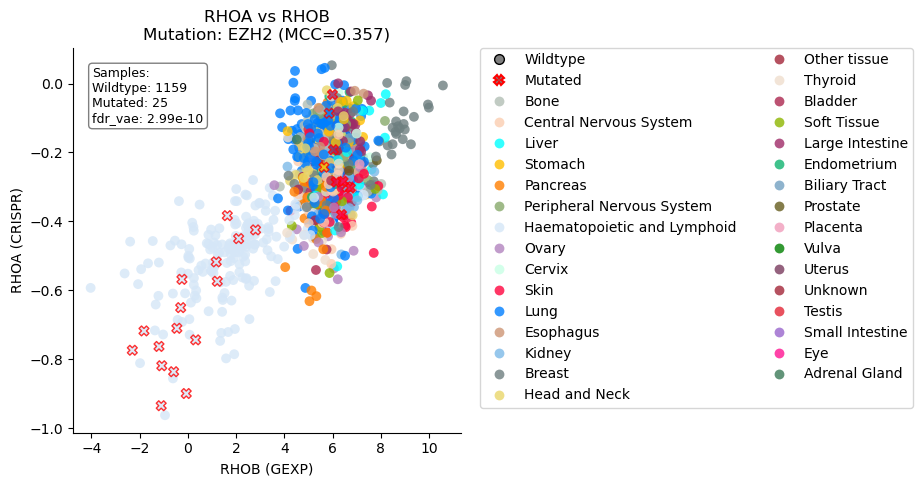

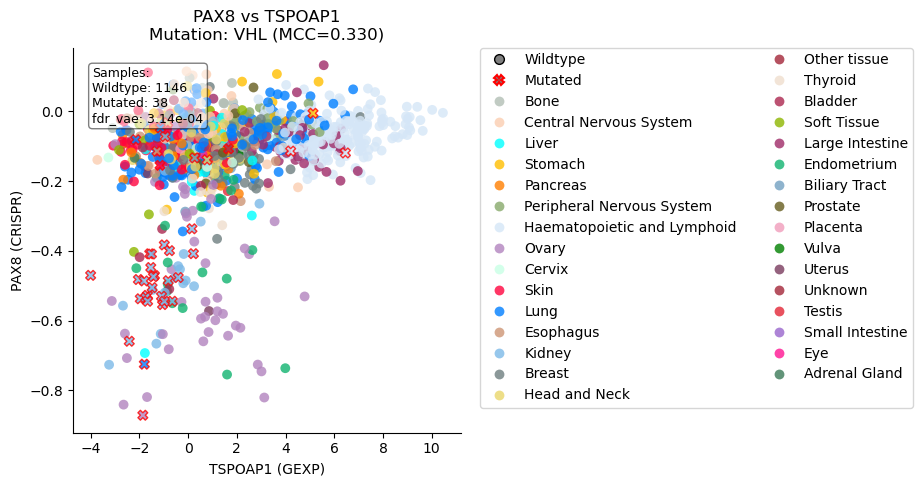

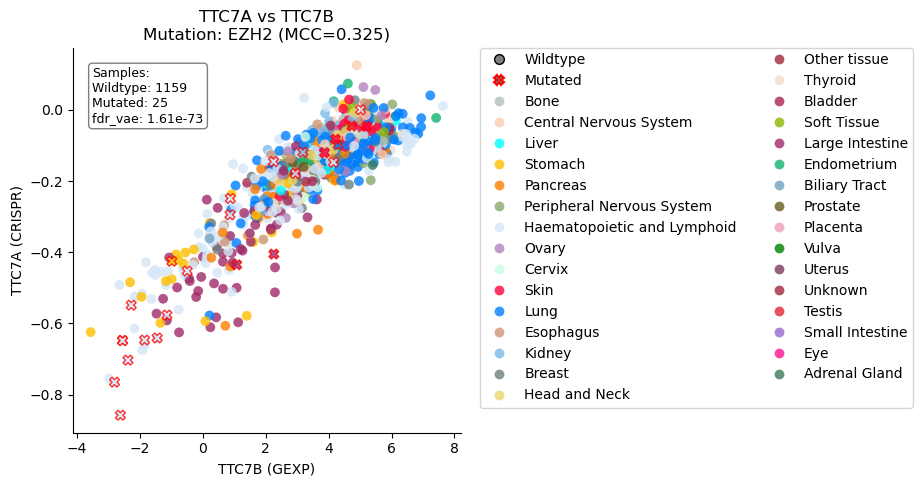

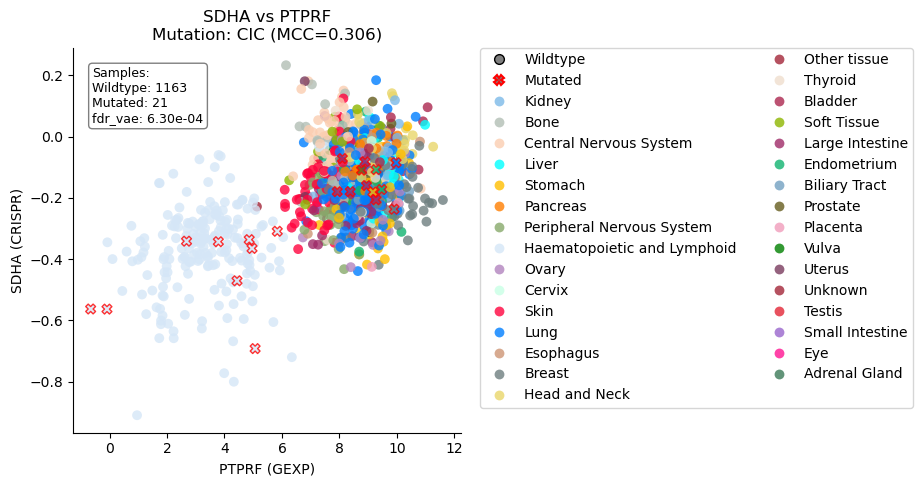

In [105]:
for i in range(10):
    plot_scatter_for_row(
        mcc_melt_df_filtered.drop_duplicates(subset=["CRISPR:GEXP"]).iloc[i],
        gexp_df,
        cas9_df,
        mutations_measured,
        tissue_map,
        PALETTE_TTYPE,
    )
    plt.show()  # Add this line to display the plot in the notebook